# Evaluation Notebook
## Irrigation Capstone Fall 2020
### TP Goter

This notebook is used for processing results from supervised and unsupervised models. We do this by plotting training and validation metrics by epoch for the supervised and finetuned models. We also evaluate models against our test set and look at AUC. What we are after is identifying what parameters during unsupervised training and finetuning lead to the highest overall AUC as compared to our supervised baseline which is identified in the cells below.

In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tqdm import tqdm


sns.set()

print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'sci-kit learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tf.__version__}')

Pandas version: 1.1.2
Numpy version: 1.18.5
sci-kit learn version: 0.23.1
Tensorflow version: 2.3.1


## Models Stored at the Path Below

In [38]:
model_path = './models'
pprint([file for file in os.listdir(model_path) if 'dummy' in file])
#os.listdir(model_path)

['simclr_dummy_ft_1perc.pkl', 'simclr_dummy_ft_1perc.h5']


## Function to Plot Metrics by Epoch

In [5]:
def plot_metrics(df, early_stop=False):
  '''
  Function for plotting the loss, auc, recall and precision by epoch
  for both training and validation sets. This function will work for both supervised
  and finetuned models.
  
  Input:
    df - Pandas DataFrame: This should contain metrics by epoch for our model.
  '''
  # Metrics are the column labels in the dataframe
  metrics = ['loss', 'auc', 'recall', 'precision']

  # Labels are show the metrics will show up in our plot legends
  labels = ['Loss',
            'AUC',
            'Recall',
            'Precision',
            'F1-Score']
  
  # had an issue with the loss column name, so rename in some cases
  if 0 in df.columns:
    df['loss'] = df.loc[:,0]
    
  # Create subplots for each metric
  fig, axes = plt.subplots(1,len(metrics)+1,
                           figsize=(len(metrics)*6,6),
                           sharex=True)
  
  # Flatten the axes object into a 1D array
  axes = axes.flatten()
  
  # Loop over the subplots an plot each metric individually for train/val data
  for a in range(len(metrics)):
    axes[a].scatter(df.index.values, df[metrics[a]], c='tab:cyan', label='Training')
    axes[a].scatter(df.index.values, df[f'val_{metrics[a]}'], c='tab:red', label='Validation')
    axes[a].legend()
    axes[a].set_ylabel(labels[a])
    if early_stop:
        axes[a].vlines(df.index.values[-1]-early_stop,
                   df[metrics[a]].min(),
                   df[metrics[a]].max())
    
    # Scale the Y-limits for the loss plot
    if a==0:
      axes[a].set_ylim((0,2))
  
  # Calculate F1 score for training and validation sets
  f1_score = 2*df.precision*df.recall / (df.precision + df.recall)
  val_f1_score = 2*df.val_precision*df.val_recall / (df.val_precision + df.val_recall)
    
  # Plot F1-score  
  axes[-1].scatter(df.index.values,
                   f1_score,
                   c='tab:cyan',
                   label='Training')
  axes[-1].scatter(df.index.values,
                   val_f1_score,
                   c='tab:red',
                   label='Validation')
  
  axes[-1].legend()
  axes[-1].set_ylabel(labels[-1])
  if early_stop:
    axes[-1].vlines(df.index.values[-1]-early_stop,
                       f1_score.min(),
                       f1_score.max())
  plt.subplots_adjust(wspace=0.30)

  print(df.val_auc.max())

## Plot for Supervised Baseline - AUC ~0.97
Note that early stopping is used, so the black vertical lines represent the epoch from which the model weights were saved.

0.9738450050354004


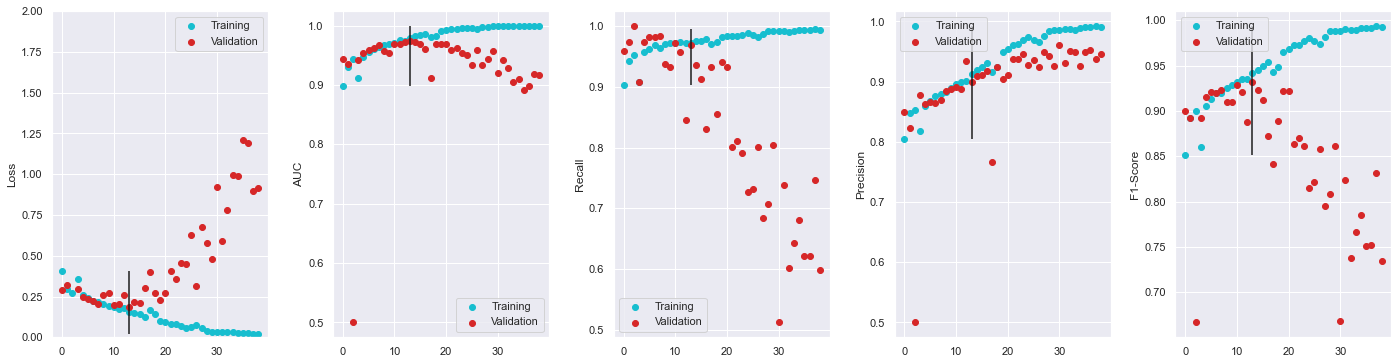

In [15]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'pooled_inception_balanced_val_all.pkl')), early_stop=25)

## Supervised Model with 13 Percent of Positive Class (640 total images)
## Supervised Model with 3 Percent of Positive Class (128 total images)

0.9646288156509399
0.9264547824859619
0.8935688138008118
0.8339868187904358


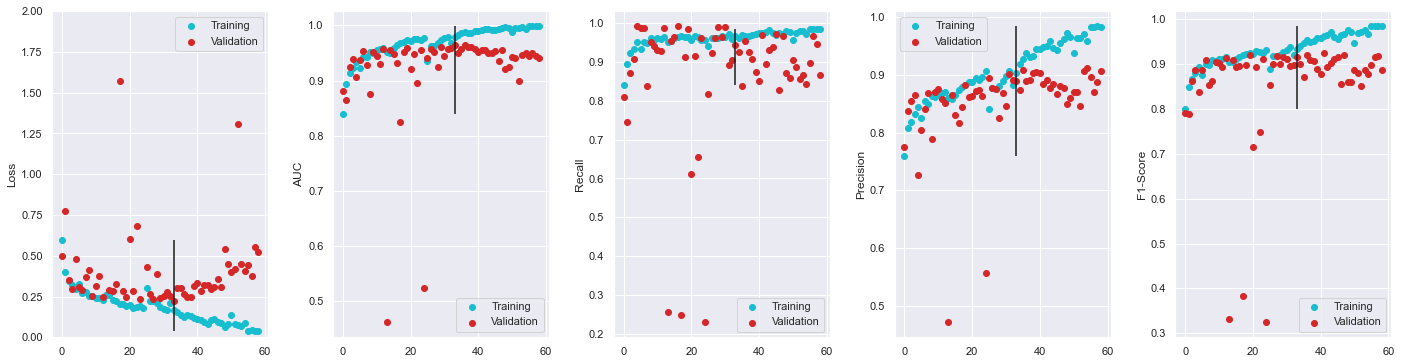

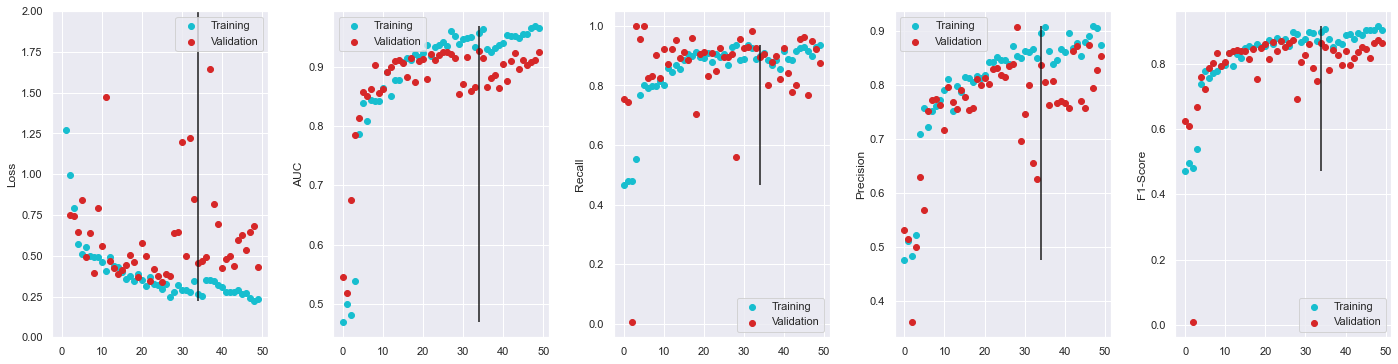

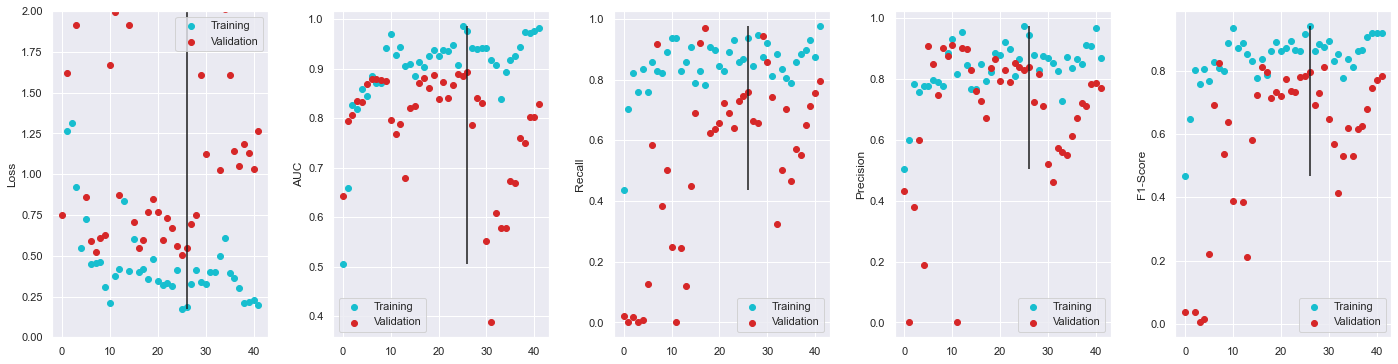

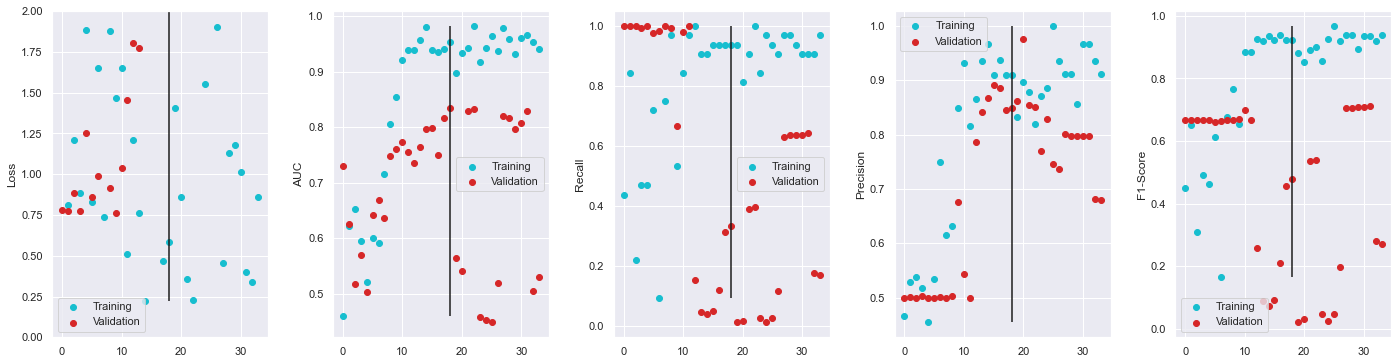

In [16]:
# 100% Training Data
plot_metrics(pd.read_pickle(os.path.join(model_path, 'pooled_inceptionv3_balanced_val_0.pkl')), early_stop=25)
# 10% Training Data (1024 total images)
plot_metrics(pd.read_pickle(os.path.join(model_path, 'sup_irr_10p_lr0001.pkl')), early_stop=15)
# 3% Training Data (256 total images)
plot_metrics(pd.read_pickle(os.path.join(model_path, 'sup_irr_3p_lr0001.pkl')), early_stop=15)
# 1% Training Data (64 total images)
plot_metrics(pd.read_pickle(os.path.join(model_path, 'sup_irr_1p_lr0001.pkl')), early_stop=15)

## Final Fine-tuned Model with 10-1 percent of Positive Class (1024 to 64 total images)
- Learning Rate: 0.00005
- Drop Out Rate: 0.50
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.3
- Batch Size: 128
- Epochs: 10
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- Color Jitter Intensity Factor: 0.5
- Gaussian Blur Probability: 0.5

0.9677342176437378
0.9473941326141357
0.9299284815788269
0.9127063751220703
0.9040220975875854


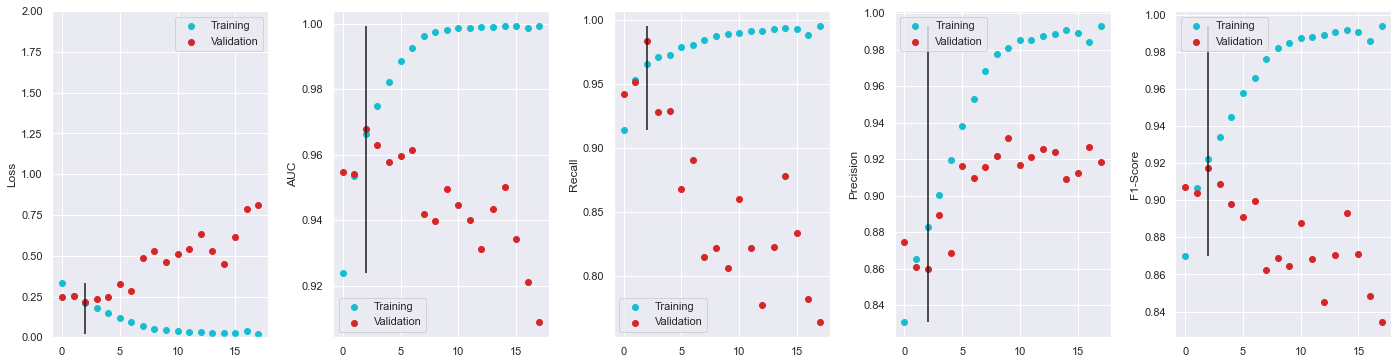

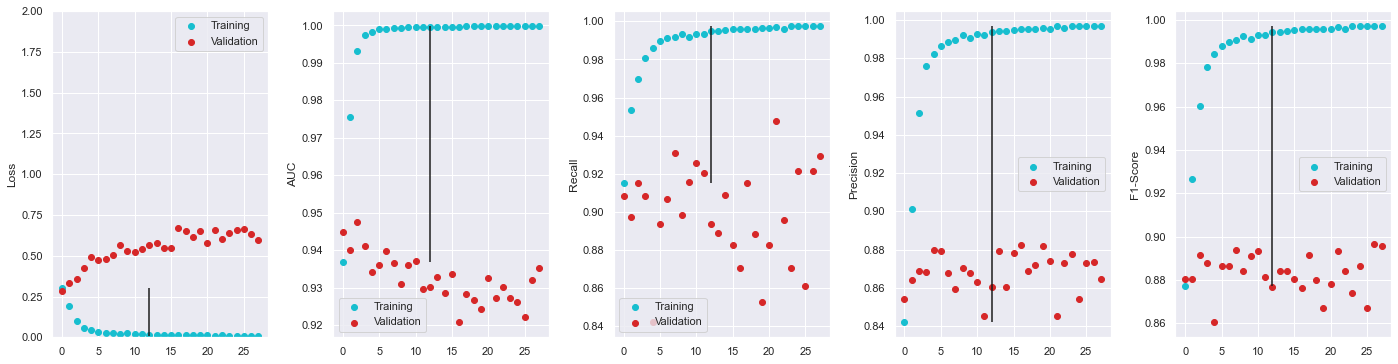

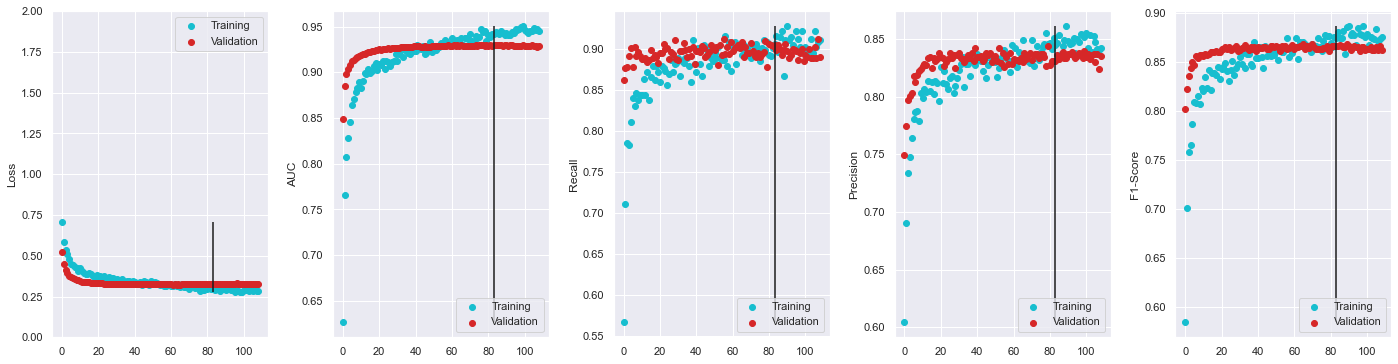

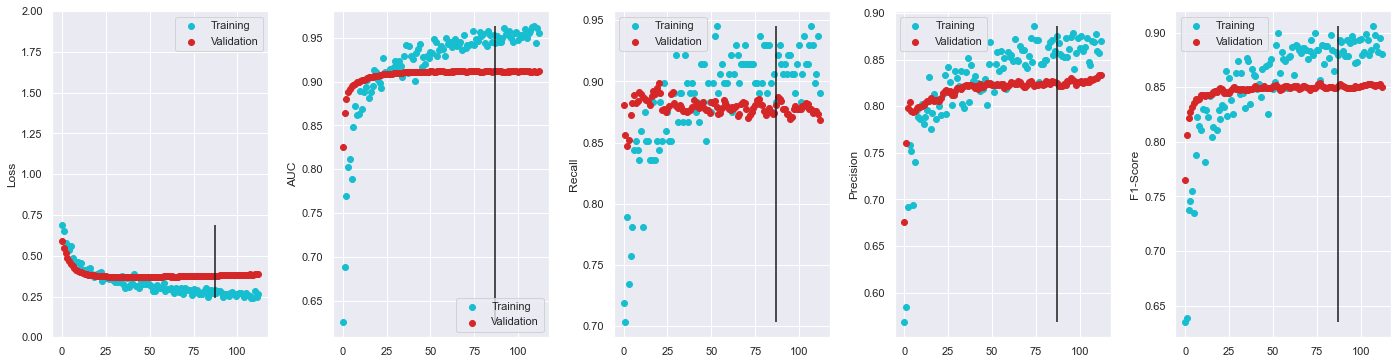

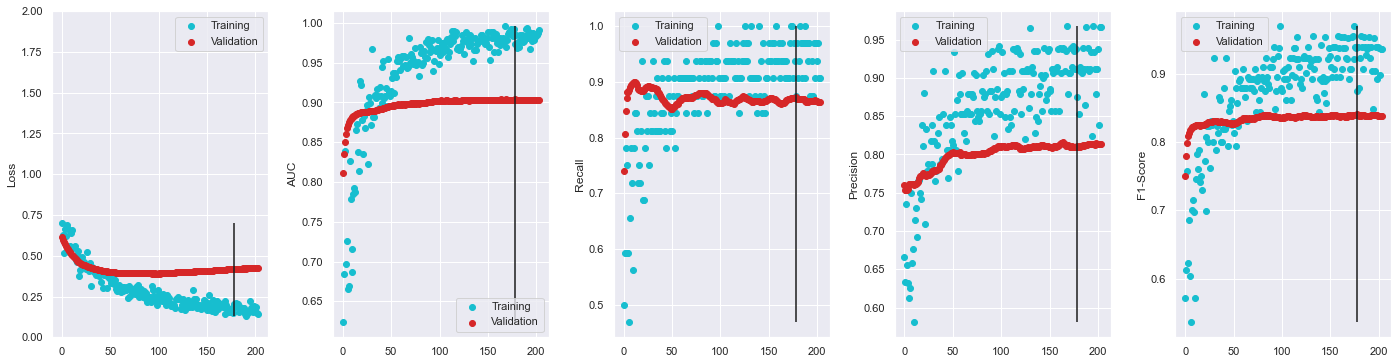

In [18]:
# Results with Upsampled Data - finetune whole network
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_500percent_do50_lr0001_s50_t3_e100_t3_fullft.pkl')), early_stop=15)

# Results with 100% Data - finetune whole network
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_ft_100_do25_lr00001_100p_10e_fullft.pkl')), early_stop=15)

# Results with 10% Data (1024) - Fine tune two layer MLP after two layers of PH in SIMCLR model
plot_metrics(pd.read_pickle(os.path.join(model_path, 'FINAL_simclr_ft_100_do50_lr00005_10p_10e.pkl')), early_stop=25)

# Results with 3% Data (256) - Fine tune two layer MLP after two layers of PH in SIMCLR model
plot_metrics(pd.read_pickle(os.path.join(model_path, 'FINAL_simclr_ft_100_do50_lr00005_3p_10e.pkl')), early_stop=25)

# Results with 1% Data (64) - Fine tune two layer MLP after two layers of PH in SIMCLR model
plot_metrics(pd.read_pickle(os.path.join(model_path, 'FINAL_simclr_ft_100_do50_lr00005_1p_10e.pkl')), early_stop=25)

## Results of Model Pretrained On California Data and then Finetuned on BigEarthNet Data

0.9267426133155823
0.9100527763366699
0.9015843272209167


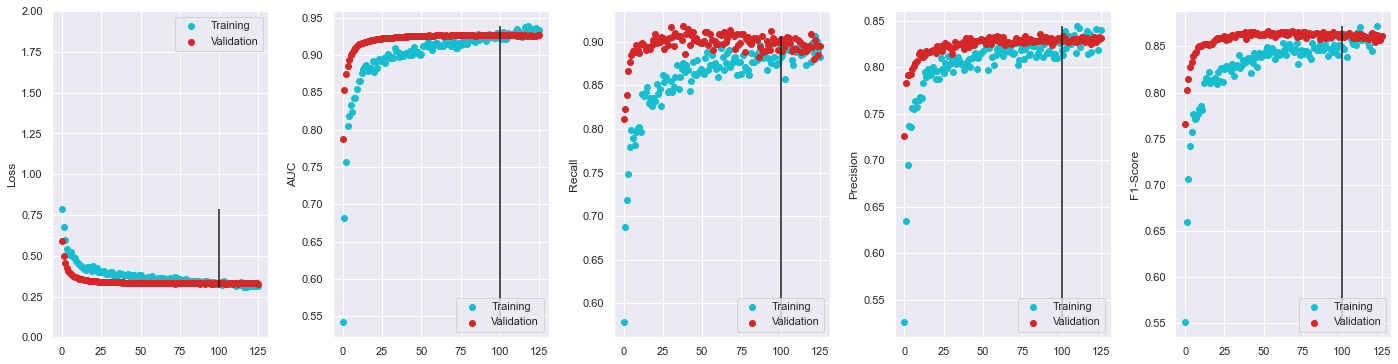

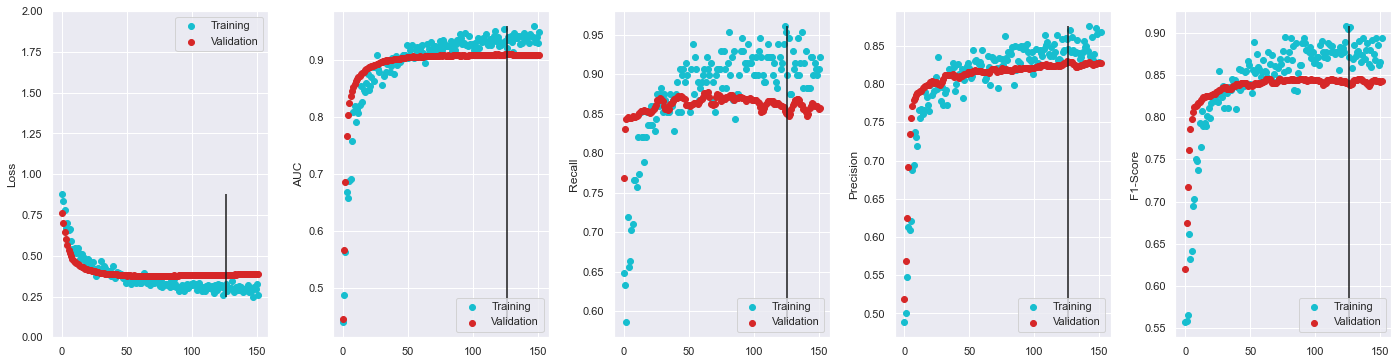

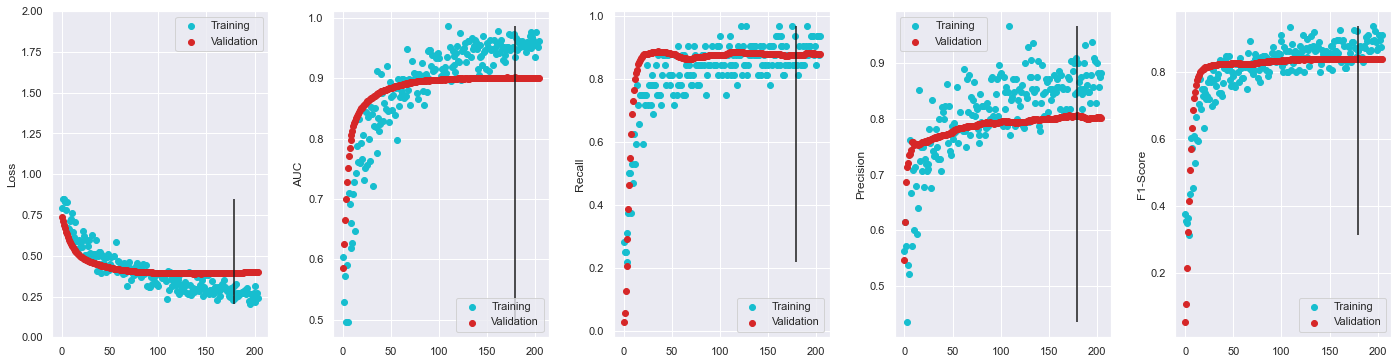

In [6]:
# Results with 10% Data (1024) - Fine tune two layer MLP after two layers of PH in SIMCLR model
plot_metrics(pd.read_pickle(os.path.join(model_path, 'ca_simclr_s50_t1_ft_10perc.pkl')), early_stop=25)

# Results with 3% Data (256) - Fine tune two layer MLP after two layers of PH in SIMCLR model
plot_metrics(pd.read_pickle(os.path.join(model_path, 'ca_simclr_s50_t1_ft_3perc.pkl')), early_stop=25)

# Results with 1% Data (64) - Fine tune two layer MLP after two layers of PH in SIMCLR model
plot_metrics(pd.read_pickle(os.path.join(model_path, 'ca_simclr_s50_t1_ft_1perc.pkl')), early_stop=25)

## Need a baseline to the finetuning - use a set of dummy weights in a ResNet101V2 Model with same finetuning process

0.8812686800956726


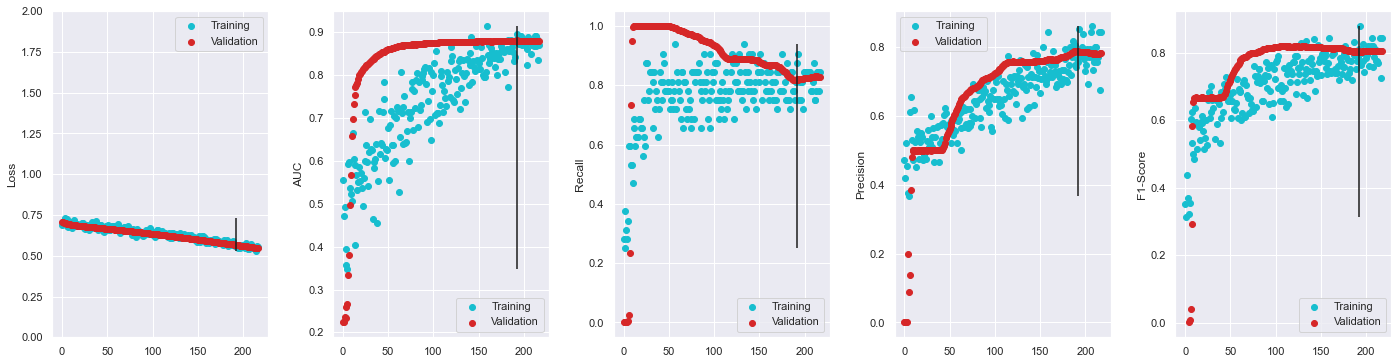

In [39]:
# Results with 1% Data (64) - Finetuned a ResNet101V2 model with dummy weights
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_dummy_ft_1perc.pkl')), early_stop=25)

## Evaluate Against Test Set
### Requires TFRecords Processing Function Below

In [40]:
def read_tfrecord(example):

    BAND_STATS = {
            'mean': {
                'B01': 340.76769064,
                'B02': 429.9430203,
                'B03': 614.21682446,
                'B04': 590.23569706,
                'B05': 950.68368468,
                'B06': 1792.46290469,
                'B07': 2075.46795189,
                'B08': 2218.94553375,
                'B8A': 2266.46036911,
                'B09': 2246.0605464,
                'B11': 1594.42694882,
                'B12': 1009.32729131
            },
            'std': {
                'B01': 554.81258967,
                'B02': 572.41639287,
                'B03': 582.87945694,
                'B04': 675.88746967,
                'B05': 729.89827633,
                'B06': 1096.01480586,
                'B07': 1273.45393088,
                'B08': 1365.45589904,
                'B8A': 1356.13789355,
                'B09': 1302.3292881,
                'B11': 1079.19066363,
                'B12': 818.86747235
            }
        }

    
    
    # Use this one-liner to standardize each feature prior to reshaping.
    def standardize_feature(data, band_name):
      return  ((tf.dtypes.cast(data, tf.float32) - BAND_STATS['mean'][band_name]) / BAND_STATS['std'][band_name])
    
    
    # decode the TFRecord
    # The parse single example methods takes an example (from a tfrecords file),
    # and a dictionary that explains the data format of each feature.
    example = tf.io.parse_single_example(example, {
                    'B01': tf.io.FixedLenFeature([20*20], tf.int64),
                    'B02': tf.io.FixedLenFeature([120*120], tf.int64),
                    'B03': tf.io.FixedLenFeature([120*120], tf.int64),
                    'B04': tf.io.FixedLenFeature([120*120], tf.int64),
                    'B05': tf.io.FixedLenFeature([60*60], tf.int64),
                    'B06': tf.io.FixedLenFeature([60*60], tf.int64),
                    'B07': tf.io.FixedLenFeature([60*60], tf.int64),
                    'B08': tf.io.FixedLenFeature([120*120], tf.int64),
                    'B8A': tf.io.FixedLenFeature([60*60], tf.int64),
                    'B09': tf.io.FixedLenFeature([20*20], tf.int64),
                    'B11': tf.io.FixedLenFeature([60*60], tf.int64),
                    'B12': tf.io.FixedLenFeature([60*60], tf.int64),
                    'patch_name': tf.io.VarLenFeature(dtype=tf.string),
                    'original_labels': tf.io.VarLenFeature(dtype=tf.string),
                    'original_labels_multi_hot': tf.io.FixedLenFeature([43], tf.int64)
                })
    
    example['binary_label'] = example['original_labels_multi_hot'][tf.constant(12)]
       
    # After parsing our data into a tensor, let's standardize and reshape.
    reshaped_example = {
            'B01': tf.reshape(standardize_feature(example['B01'],'B01'), [20, 20]),
            'B02': tf.reshape(standardize_feature(example['B02'],'B02'), [120, 120]),
            'B03': tf.reshape(standardize_feature(example['B03'],'B03'), [120, 120]),
            'B04': tf.reshape(standardize_feature(example['B04'],'B04'), [120, 120]),
            'B05': tf.reshape(standardize_feature(example['B05'],'B05'), [60, 60]),
            'B06': tf.reshape(standardize_feature(example['B06'],'B06'), [60, 60]),
            'B07': tf.reshape(standardize_feature(example['B07'],'B07'), [60, 60]),
            'B08': tf.reshape(standardize_feature(example['B08'],'B08'), [120, 120]),
            'B8A': tf.reshape(standardize_feature(example['B8A'],'B8A'), [60, 60]),
            'B09': tf.reshape(standardize_feature(example['B09'],'B09'), [20, 20]),
            'B11': tf.reshape(standardize_feature(example['B11'],'B11'), [60, 60]),
            'B12': tf.reshape(standardize_feature(example['B12'],'B12'), [60, 60]),
            'patch_name': example['patch_name'],
            'original_labels': example['original_labels'],
            'original_labels_multi_hot': example['original_labels_multi_hot'],
            'binary_labels': example['binary_label']
        }
    

    # Next sort the layers by resolution
    bands_10m = tf.stack([reshaped_example['B04'],
                          reshaped_example['B03'],
                          reshaped_example['B02'],
                          reshaped_example['B08']], axis=2)
    
    bands_20m = tf.stack([reshaped_example['B05'],
                          reshaped_example['B06'],
                          reshaped_example['B07'],
                          reshaped_example['B8A'],
                          reshaped_example['B11'],
                          reshaped_example['B12']], axis=2)
    
    # Finally resize the 20m data and stack the bands together.
    img = tf.concat([bands_10m , tf.image.resize(bands_20m, [120, 120],method='bicubic')], axis=2)

    multi_hot_label = reshaped_example['original_labels_multi_hot']
    binary_label = reshaped_example['binary_labels']

    return img, binary_label

def get_batched_dataset(filenames, batch_size):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.list_files(filenames, shuffle=False)
  print(f'Filenames: {filenames}')
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=2, num_parallel_calls=1)
  dataset = dataset.shuffle(buffer_size=2048)
  
  dataset = dataset.map(read_tfrecord, num_parallel_calls=10)
  dataset = dataset.batch(batch_size, drop_remainder=False) # drop_remainder will be needed on TPU
  batched_dataset = tf.compat.v1.data.make_one_shot_iterator(dataset)
  
  return dataset
  
def get_test_dataset(test_filenames, batch_size):
  return get_batched_dataset(test_filenames, batch_size)

## Function for Plotting the ROC Curve

In [8]:
def plot_roc_full(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=3, **kwargs)
  plt.xlabel('False positives [%] (1-specificity)', fontweight='bold', fontsize=16)
  plt.ylabel('True positives [%] (sensitivity or recall)', fontweight='bold', fontsize=16)
  plt.xlim([0,40])
  plt.ylim([60,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def plot_pr_full(name, labels, predictions, **kwargs):
  precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
  plt.plot(recall, precision, label=name, linewidth=3, **kwargs)
  plt.xlabel('Recall)', fontweight='bold', fontsize=16)
  plt.ylabel('Precision', fontweight='bold', fontsize=16)
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Look at Results with Balanced and Skewed Test Data Sets
- Balanced Test Set has equal proportion of positive/negative examples
- Skewed Test Set has 90% negative examples

In [9]:
balanced_test_data = get_test_dataset('./tfrecords/balanced_test.tfrecord', batch_size=32)
skewed_test_data = get_test_dataset('./tfrecords/10percent_test.tfrecord', batch_size=32)

Filenames: ./tfrecords/balanced_test.tfrecord
Filenames: ./tfrecords/10percent_test.tfrecord


In [26]:
# Dictionary with all of the models we will evaluate against the test sets.
models_dict = { 'Supervised Baseline': 'pooled_inception_balanced_val_all.h5',
                'Supervised 100%' : 'pooled_inceptionv3_balanced_val_0.h5',
               'Supervised 10%' : 'sup_irr_10p_lr0001.h5',
               'Supervised 3%' : 'sup_irr_3p_lr0001.h5',
               'Supervised 1%' : 'sup_irr_1p_lr0001.h5',
               'SimCLR 500%' : 'simclr_finetune_500percent_do50_lr0001_s50_t3_e100_t3_fullft.h5',
               'SimCLR 100%' : 'simclr_ft_100_do25_lr00001_100p_10e_fullft.h5',
               'SimCLR 10%' : 'FINAL_simclr_ft_100_do50_lr00005_10p_10e.h5',
               'SimCLR 3%' : 'FINAL_simclr_ft_100_do50_lr00005_3p_10e.h5',
               'SimCLR 1%' : 'FINAL_simclr_ft_100_do50_lr00005_1p_10e.h5'
              }

### Balanced Test Set

In [41]:
predictions = {key:[] for key in models_dict.keys()}
labels = {key:[] for key in models_dict.keys()}
for label, file in tqdm(models_dict.items()):
    model = tf.keras.models.load_model(os.path.join(model_path, file))
    for image_batch, label_batch in balanced_test_data: 
        preds = model.predict(image_batch)
        predictions[label].append(preds)
        labels[label].append(label_batch.numpy())
    del model


100%|██████████| 10/10 [36:44<00:00, 220.48s/it]


### Skewed Test Set

In [56]:
skewed_predictions = {key:[] for key in models_dict.keys()}
skewed_labels = {key:[] for key in models_dict.keys()}
for label, file in tqdm(models_dict.items()):
    model = tf.keras.models.load_model(os.path.join(model_path, file))
    for image_batch, label_batch in skewed_test_data: 
        preds = model.predict(image_batch)
        skewed_predictions[label].append(preds)
        skewed_labels[label].append(label_batch.numpy())
    del model

100%|██████████| 10/10 [3:58:35<00:00, 1431.58s/it] 


In [11]:
models_dict = {
               'CA SimCLR 10%' : 'ca_simclr_s50_t1_ft_10perc.h5',
               'CA SimCLR 3%' : 'ca_simclr_s50_t1_ft_3perc.h5',
               'CA SimCLR 1%' : 'ca_simclr_s50_t1_ft_1perc.h5'
              }

In [13]:
ca_based_predictions = {key:[] for key in models_dict.keys()}
ca_based_labels = {key:[] for key in models_dict.keys()}
for label, file in tqdm(models_dict.items()):
    model = tf.keras.models.load_model(os.path.join(model_path, file))
    for image_batch, label_batch in balanced_test_data: 
        preds = model.predict(image_batch)
        ca_based_predictions[label].append(preds)
        ca_based_labels[label].append(label_batch.numpy())
    del model

100%|██████████| 3/3 [06:29<00:00, 129.74s/it]


In [41]:
models_dict = {
               'Dummy SimCLR 1%' : 'simclr_dummy_ft_1perc.h5'
              }

dummy_predictions = {key:[] for key in models_dict.keys()}
dummy_labels = {key:[] for key in models_dict.keys()}
for label, file in tqdm(models_dict.items()):
    model = tf.keras.models.load_model(os.path.join(model_path, file))
    for image_batch, label_batch in balanced_test_data: 
        preds = model.predict(image_batch)
        dummy_predictions[label].append(preds)
        dummy_labels[label].append(label_batch.numpy())
    del model

100%|██████████| 1/1 [02:15<00:00, 135.55s/it]


### Store Predictions and Labels for Future Retrieval

In [64]:
balanced_test_pred_df = pd.DataFrame.from_dict(predictions)
balanced_test_labels_df = pd.DataFrame.from_dict(labels)
skewed_test_pred_df = pd.DataFrame.from_dict(skewed_predictions)
skewed_test_labels_df = pd.DataFrame.from_dict(skewed_labels)

In [14]:
ca_balanced_test_pred_df = pd.DataFrame.from_dict(ca_based_predictions)
ca_balanced_test_labels_df = pd.DataFrame.from_dict(ca_based_labels)

In [65]:
balanced_test_pred_df.to_pickle(os.path.join(model_path, 'balanced_test_preds.pkl'))
balanced_test_labels_df.to_pickle(os.path.join(model_path, 'balanced_test_labels.pkl'))
skewed_test_pred_df.to_pickle(os.path.join(model_path, 'skewed_test_preds.pkl'))
skewed_test_labels_df.to_pickle(os.path.join(model_path, 'skewed_test_labels.pkl'))

In [15]:
ca_balanced_test_pred_df.to_pickle(os.path.join(model_path, 'ca_balanced_test_preds.pkl'))
ca_balanced_test_labels_df.to_pickle(os.path.join(model_path, 'ca_balanced_test_labels.pkl'))

In [42]:
dummy_balanced_test_pred_df = pd.DataFrame.from_dict(dummy_predictions)
dummy_balanced_test_labels_df = pd.DataFrame.from_dict(dummy_labels)
dummy_balanced_test_pred_df.to_pickle(os.path.join(model_path, 'dummy_balanced_test_preds.pkl'))
dummy_balanced_test_labels_df.to_pickle(os.path.join(model_path, 'dummy_balanced_test_labels.pkl'))

## Read in Predictions and Labels to avoid having to Rerun the models

In [16]:
balanced_test_pred_df = pd.read_pickle(os.path.join(model_path, 'balanced_test_preds.pkl'))
balanced_test_labels_df = pd.read_pickle(os.path.join(model_path, 'balanced_test_labels.pkl'))
predictions = balanced_test_pred_df.to_dict()
labels = balanced_test_labels_df.to_dict()

In [19]:
balanced_test_pred_df.head()

,Supervised Baseline,Supervised 100%,Supervised 10%,Supervised 3%,Supervised 1%,SimCLR 500%,SimCLR 100%,SimCLR 10%,SimCLR 3%,SimCLR 1%
0,"[[0.96134317], [0.97394335], [2.1765783e-07], ...","[[0.43330598], [7.2049916e-10], [0.85246706], ...","[[0.9913926], [0.9824891], [0.9998854], [0.986...","[[0.056876242], [0.0050486326], [0.3150495], [...","[[0.049999446], [0.08648941], [0.12515116], [1...","[[0.00020334125], [0.79772687], [0.9696617], [...","[[1.7316115e-07], [0.99970543], [0.11080903], ...","[[0.730935], [0.9765559], [0.97846746], [0.910...","[[0.74143934], [0.9288558], [0.008174747], [0....","[[0.9855859], [0.06735635], [0.73864996], [0.0..."
1,"[[0.9939333], [2.399131e-06], [0.95928377], [7...","[[1.3209453e-10], [0.0047029257], [0.926914], ...","[[0.0015758872], [0.98895204], [0.00097191334]...","[[0.0037711263], [0.9770179], [0.3426531], [0....","[[0.120280445], [0.12669599], [0.09924257], [0...","[[0.9772711], [0.57949847], [0.00010548061], [...","[[0.960829], [1.9382203e-05], [0.025147438], [...","[[0.97306263], [0.0031543374], [0.00079861283]...","[[0.97752404], [0.34945118], [0.05563572], [0....","[[0.8846203], [0.98367065], [0.012859553], [0...."
2,"[[4.6637194e-07], [0.9882648], [0.9997429], [0...","[[6.9209155e-10], [3.181448e-09], [6.4189994e-...","[[6.151273e-13], [0.0010709763], [0.97985244],...","[[0.1016275], [0.85024035], [0.98875594], [0.9...","[[0.21517494], [0.06066835], [0.06942049], [1....","[[0.97845435], [1.0340695e-05], [0.99672055], ...","[[0.97311056], [0.00331074], [2.1826375e-07], ...","[[0.049823463], [0.07658917], [0.004933566], [...","[[0.90668416], [0.009905547], [0.014632642], [...","[[0.009752989], [0.98238575], [0.9849409], [0...."
3,"[[0.9965294], [0.7409152], [0.8801903], [3.153...","[[0.9536122], [6.3624987e-07], [0.029905647], ...","[[0.013565898], [0.0006144643], [0.9697304], [...","[[1.2412464e-11], [0.09897837], [0.071505696],...","[[0.08925253], [0.08482528], [0.44322824], [0....","[[1.2285548e-05], [0.8663125], [0.9706747], [0...","[[8.21017e-05], [0.79430157], [0.9991244], [0....","[[0.009377301], [0.00027889013], [3.656447e-05...","[[0.051392585], [0.96051455], [0.76845825], [0...","[[0.9255253], [0.5830835], [0.9922498], [0.438..."
4,"[[0.9987238], [0.9979731], [0.0021720827], [5....","[[0.9969196], [0.30050054], [0.75653636], [7.7...","[[0.97897685], [0.99726856], [0.030886829], [0...","[[0.6097527], [0.05743611], [0.05947581], [0.0...","[[0.062056214], [0.089212775], [0.13891578], [...","[[2.7045326e-06], [0.98363936], [8.554513e-05]...","[[9.053319e-06], [0.99968904], [5.536033e-07],...","[[0.9567416], [0.9823209], [0.0035408735], [0....","[[0.62187415], [0.02951309], [0.7416696], [0.8...","[[0.009294659], [0.026883096], [0.95492566], [..."


### Clean Up Workspace

Only do this after you are done with plotting below

In [66]:
del balanced_test_labels_df, balanced_test_pred_df, skewed_test_labels_df, skewed_test_pred_df
del predictions, labels, skewed_predictions, skewed_labels

## Plot the Test Set Results

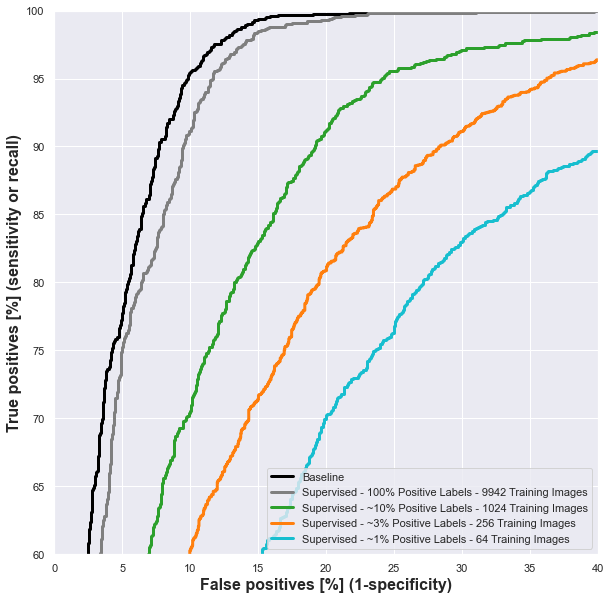

In [50]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_roc_full(f"Baseline", 
              np.concatenate(labels['Supervised Baseline']),
              np.concatenate(predictions['Supervised Baseline']),
              color='black')
plot_roc_full(f"Supervised - 100% Positive Labels - 9942 Training Images",
              np.concatenate(labels['Supervised 100%']),
              np.concatenate(predictions['Supervised 100%']),
              color='tab:gray')
plot_roc_full(f"Supervised - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(labels['Supervised 10%']),
              np.concatenate(predictions['Supervised 10%']),
              color='tab:green')
plot_roc_full(f"Supervised - ~3% Positive Labels - 256 Training Images",
              np.concatenate(labels['Supervised 3%']),
              np.concatenate(predictions['Supervised 3%']),
              color='tab:orange')
plot_roc_full(f"Supervised - ~1% Positive Labels - 64 Training Images",
              np.concatenate(labels['Supervised 1%']),
              np.concatenate(predictions['Supervised 1%']),
              color='tab:cyan')
plt.legend(loc='lower right')

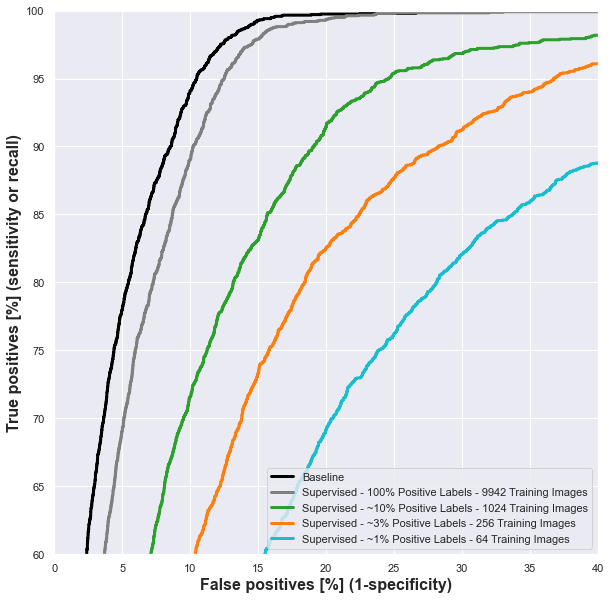

In [57]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_roc_full(f"Baseline", 
              np.concatenate(skewed_labels['Supervised Baseline']),
              np.concatenate(skewed_predictions['Supervised Baseline']),
              color='black')
plot_roc_full(f"Supervised - 100% Positive Labels - 9942 Training Images",
              np.concatenate(skewed_labels['Supervised 100%']),
              np.concatenate(skewed_predictions['Supervised 100%']),
              color='tab:gray')
plot_roc_full(f"Supervised - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(skewed_labels['Supervised 10%']),
              np.concatenate(skewed_predictions['Supervised 10%']),
              color='tab:green')
plot_roc_full(f"Supervised - ~3% Positive Labels - 256 Training Images",
              np.concatenate(skewed_labels['Supervised 3%']),
              np.concatenate(skewed_predictions['Supervised 3%']),
              color='tab:orange')
plot_roc_full(f"Supervised - ~1% Positive Labels - 64 Training Images",
              np.concatenate(skewed_labels['Supervised 1%']),
              np.concatenate(skewed_predictions['Supervised 1%']),
              color='tab:cyan')
plt.legend(loc='lower right')

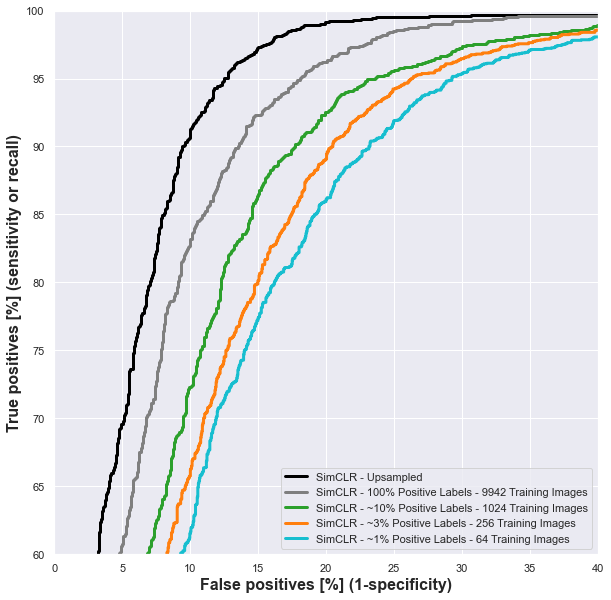

In [51]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_roc_full(f"SimCLR - Upsampled", 
              np.concatenate(labels['SimCLR 500%']),
              np.concatenate(predictions['SimCLR 500%']),
              color='black')
plot_roc_full(f"SimCLR - 100% Positive Labels - 9942 Training Images",
              np.concatenate(labels['SimCLR 100%']),
              np.concatenate(predictions['SimCLR 100%']),
              color='tab:gray')
plot_roc_full(f"SimCLR - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(labels['SimCLR 10%']),
              np.concatenate(predictions['SimCLR 10%']),
              color='tab:green')
plot_roc_full(f"SimCLR - ~3% Positive Labels - 256 Training Images",
              np.concatenate(labels['SimCLR 3%']),
              np.concatenate(predictions['SimCLR 3%']),
              color='tab:orange')
plot_roc_full(f"SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate(labels['SimCLR 1%']),
              np.concatenate(predictions['SimCLR 1%']),
              color='tab:cyan')
plt.legend(loc='lower right')

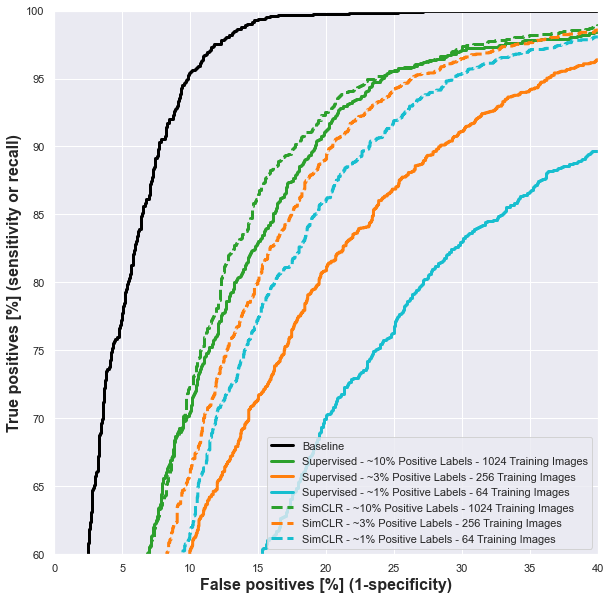

In [49]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_roc_full(f"Baseline", 
              np.concatenate(labels['Supervised Baseline']),
              np.concatenate(predictions['Supervised Baseline']),
              color='black')
plot_roc_full(f"Supervised - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(labels['Supervised 10%']),
              np.concatenate(predictions['Supervised 10%']),
              color='tab:green')
plot_roc_full(f"Supervised - ~3% Positive Labels - 256 Training Images",
              np.concatenate(labels['Supervised 3%']),
              np.concatenate(predictions['Supervised 3%']),
              color='tab:orange')
plot_roc_full(f"Supervised - ~1% Positive Labels - 64 Training Images",
              np.concatenate(labels['Supervised 1%']),
              np.concatenate(predictions['Supervised 1%']),
              color='tab:cyan')
plot_roc_full(f"SimCLR - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(labels['SimCLR 10%']),
              np.concatenate(predictions['SimCLR 10%']),
              color='tab:green',
             linestyle = '--')
plot_roc_full(f"SimCLR - ~3% Positive Labels - 256 Training Images",
              np.concatenate(labels['SimCLR 3%']),
              np.concatenate(predictions['SimCLR 3%']),
              color='tab:orange',
             linestyle = '--')
plot_roc_full(f"SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate(labels['SimCLR 1%']),
              np.concatenate(predictions['SimCLR 1%']),
              color='tab:cyan',
             linestyle = '--')
plt.legend(loc='lower right')

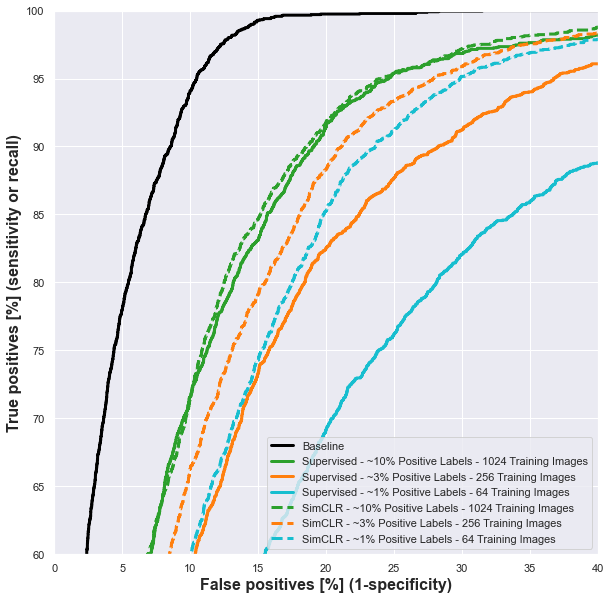

In [58]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_roc_full(f"Baseline", 
              np.concatenate(skewed_labels['Supervised Baseline']),
              np.concatenate(skewed_predictions['Supervised Baseline']),
              color='black')
plot_roc_full(f"Supervised - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(skewed_labels['Supervised 10%']),
              np.concatenate(skewed_predictions['Supervised 10%']),
              color='tab:green')
plot_roc_full(f"Supervised - ~3% Positive Labels - 256 Training Images",
              np.concatenate(skewed_labels['Supervised 3%']),
              np.concatenate(skewed_predictions['Supervised 3%']),
              color='tab:orange')
plot_roc_full(f"Supervised - ~1% Positive Labels - 64 Training Images",
              np.concatenate(skewed_labels['Supervised 1%']),
              np.concatenate(skewed_predictions['Supervised 1%']),
              color='tab:cyan')
plot_roc_full(f"SimCLR - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(skewed_labels['SimCLR 10%']),
              np.concatenate(skewed_predictions['SimCLR 10%']),
              color='tab:green',
             linestyle = '--')
plot_roc_full(f"SimCLR - ~3% Positive Labels - 256 Training Images",
              np.concatenate(skewed_labels['SimCLR 3%']),
              np.concatenate(skewed_predictions['SimCLR 3%']),
              color='tab:orange',
             linestyle = '--')
plot_roc_full(f"SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate(skewed_labels['SimCLR 1%']),
              np.concatenate(skewed_predictions['SimCLR 1%']),
              color='tab:cyan',
             linestyle = '--')
plt.legend(loc='lower right')

## Supervised Compared to Pretrained on California Data and Finetuned on BEN Data

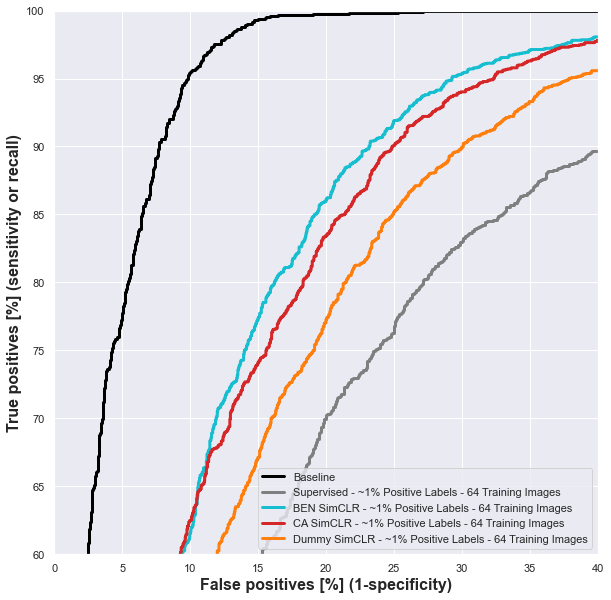

In [43]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_roc_full(f"Baseline", 
              np.concatenate([value for value in labels['Supervised Baseline'].values()]),
              np.concatenate([value for value in predictions['Supervised Baseline'].values()]),
              color='black')
plot_roc_full(f"Supervised - ~1% Positive Labels - 64 Training Images",
              np.concatenate([value for value in labels['Supervised 1%'].values()]),
              np.concatenate([value for value in predictions['Supervised 1%'].values()]),
              color='tab:gray')
plot_roc_full(f"BEN SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate([value for value in labels['SimCLR 1%'].values()]),
              np.concatenate([value for value in predictions['SimCLR 1%'].values()]),
              color='tab:cyan',
             linestyle = '-')
plot_roc_full(f"CA SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate(ca_based_labels['CA SimCLR 1%']),
              np.concatenate(ca_based_predictions['CA SimCLR 1%']),
              color='tab:red',
             linestyle = '-')
plot_roc_full(f"Dummy SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate(dummy_labels['Dummy SimCLR 1%']),
              np.concatenate(dummy_predictions['Dummy SimCLR 1%']),
              color='tab:orange',
             linestyle = '-')
plt.legend(loc='lower right')

## Look at F1 Score for Comparison

In [62]:
baseline_truth = np.round(np.concatenate([value for value in labels['Supervised Baseline'].values()]),0)
baseline_pred = np.round(np.concatenate([value for value in predictions['Supervised Baseline'].values()]),0)
s1_truth = np.round(np.concatenate([value for value in labels['Supervised 1%'].values()]),0)
s1_pred = np.round(np.concatenate([value for value in predictions['Supervised 1%'].values()]),0)
sim1_truth = np.round(np.concatenate([value for value in labels['SimCLR 1%'].values()]),0)
sim1_pred = np.round(np.concatenate([value for value in predictions['SimCLR 1%'].values()]),0)
ca_sim1_truth = np.round(np.concatenate(ca_based_labels['CA SimCLR 1%']),0)
ca_sim1_pred = np.round(np.concatenate(ca_based_predictions['CA SimCLR 1%']),0)
s3_truth = np.round(np.concatenate([value for value in labels['Supervised 3%'].values()]),0)
s3_pred = np.round(np.concatenate([value for value in predictions['Supervised 3%'].values()]),0)
sim3_truth = np.round(np.concatenate([value for value in labels['SimCLR 3%'].values()]),0)
sim3_pred = np.round(np.concatenate([value for value in predictions['SimCLR 3%'].values()]),0)
ca_sim3_truth = np.round(np.concatenate(ca_based_labels['CA SimCLR 3%']),0)
ca_sim3_pred = np.round(np.concatenate(ca_based_predictions['CA SimCLR 3%']),0)
s10_truth = np.round(np.concatenate([value for value in labels['Supervised 10%'].values()]),0)
s10_pred = np.round(np.concatenate([value for value in predictions['Supervised 10%'].values()]),0)
sim10_truth = np.round(np.concatenate([value for value in labels['SimCLR 10%'].values()]),0)
sim10_pred = np.round(np.concatenate([value for value in predictions['SimCLR 10%'].values()]),0)
ca_sim10_truth = np.round(np.concatenate(ca_based_labels['CA SimCLR 10%']),0)
ca_sim10_pred = np.round(np.concatenate(ca_based_predictions['CA SimCLR 10%']),0)
dummy_sim1_truth = np.round(np.concatenate(dummy_labels['Dummy SimCLR 1%']),0)
dummy_sim1_pred = np.round(np.concatenate(dummy_predictions['Dummy SimCLR 1%']),0)

In [63]:
print(f"Upsampled Baseline F1: {sklearn.metrics.f1_score(baseline_truth, baseline_pred)}")
print(f"Supervised with 10% Data F1: {sklearn.metrics.f1_score(s10_truth, s10_pred)}")
print(f"BEN SimCLR with 10% Data F1: {sklearn.metrics.f1_score(sim10_truth, sim10_pred)}")
print(f"CA SimCLR with 10% Data F1: {sklearn.metrics.f1_score(ca_sim10_truth, ca_sim10_pred)}")
print(f"Supervised with 3% Data F1: {sklearn.metrics.f1_score(s3_truth, s3_pred)}")
print(f"BEN SimCLR with 3% Data F1: {sklearn.metrics.f1_score(sim3_truth, sim3_pred)}")
print(f"CA SimCLR with 3% Data F1: {sklearn.metrics.f1_score(ca_sim3_truth, ca_sim3_pred)}")
print(f"Supervised with 1% Data F1: {sklearn.metrics.f1_score(s1_truth, s1_pred)}")
print(f"BEN SimCLR with 1% Data F1: {sklearn.metrics.f1_score(sim1_truth, sim1_pred)}")
print(f"CA SimCLR with 1% Data F1: {sklearn.metrics.f1_score(ca_sim1_truth, ca_sim1_pred)}")
print(f"Dummy SimCLR with 1% Data F1: {sklearn.metrics.f1_score(dummy_sim1_truth, dummy_sim1_pred)}")

Upsampled Baseline F1: 0.9292558613659533
Supervised with 10% Data F1: 0.8577235772357724
BEN SimCLR with 10% Data F1: 0.8652944772773589
CA SimCLR with 10% Data F1: 0.8521598053133238
Supervised with 3% Data F1: 0.7767936226749336
BEN SimCLR with 3% Data F1: 0.8490180032733224
CA SimCLR with 3% Data F1: 0.8179907524169819
Supervised with 1% Data F1: 0.45460085313833026
BEN SimCLR with 1% Data F1: 0.8361489924689599
CA SimCLR with 1% Data F1: 0.8245828245828245
Dummy SimCLR with 1% Data F1: 0.7977736549165121


## Precision Recall Curve

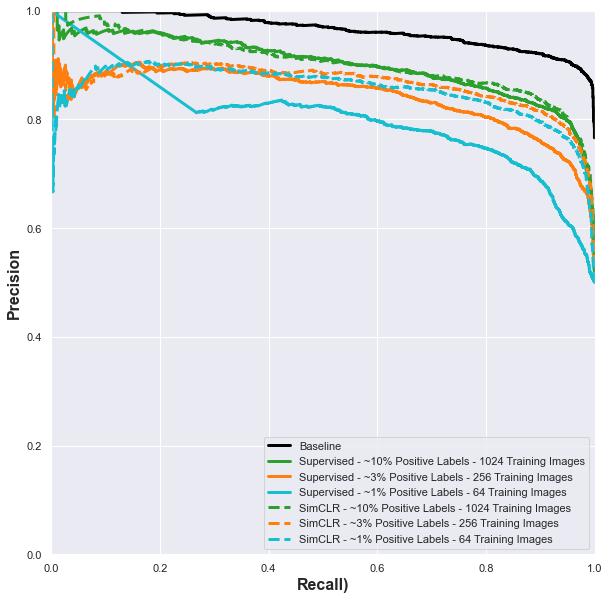

In [55]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_pr_full(f"Baseline", 
              np.concatenate(labels['Supervised Baseline']),
              np.concatenate(predictions['Supervised Baseline']),
              color='black')
plot_pr_full(f"Supervised - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(labels['Supervised 10%']),
              np.concatenate(predictions['Supervised 10%']),
              color='tab:green')
plot_pr_full(f"Supervised - ~3% Positive Labels - 256 Training Images",
              np.concatenate(labels['Supervised 3%']),
              np.concatenate(predictions['Supervised 3%']),
              color='tab:orange')
plot_pr_full(f"Supervised - ~1% Positive Labels - 64 Training Images",
              np.concatenate(labels['Supervised 1%']),
              np.concatenate(predictions['Supervised 1%']),
              color='tab:cyan')
plot_pr_full(f"SimCLR - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(labels['SimCLR 10%']),
              np.concatenate(predictions['SimCLR 10%']),
              color='tab:green',
             linestyle = '--')
plot_pr_full(f"SimCLR - ~3% Positive Labels - 256 Training Images",
              np.concatenate(labels['SimCLR 3%']),
              np.concatenate(predictions['SimCLR 3%']),
              color='tab:orange',
             linestyle = '--')
plot_pr_full(f"SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate(labels['SimCLR 1%']),
              np.concatenate(predictions['SimCLR 1%']),
              color='tab:cyan',
             linestyle = '--')
plt.legend(loc='lower right')

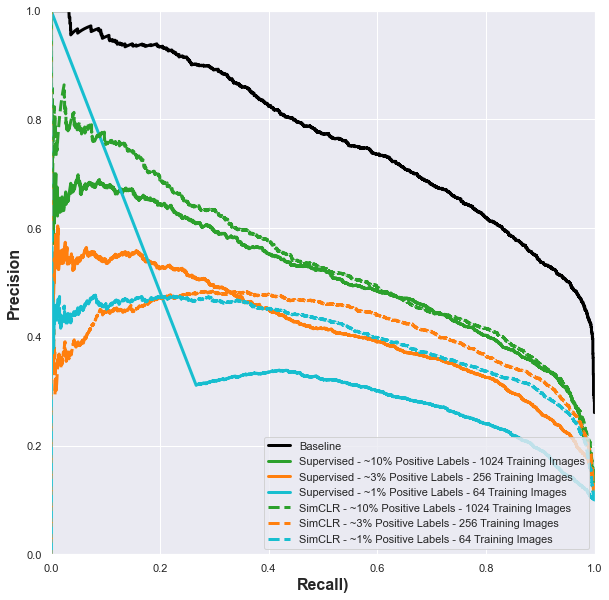

In [59]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plot_pr_full(f"Baseline", 
              np.concatenate(skewed_labels['Supervised Baseline']),
              np.concatenate(skewed_predictions['Supervised Baseline']),
              color='black')
plot_pr_full(f"Supervised - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(skewed_labels['Supervised 10%']),
              np.concatenate(skewed_predictions['Supervised 10%']),
              color='tab:green')
plot_pr_full(f"Supervised - ~3% Positive Labels - 256 Training Images",
              np.concatenate(skewed_labels['Supervised 3%']),
              np.concatenate(skewed_predictions['Supervised 3%']),
              color='tab:orange')
plot_pr_full(f"Supervised - ~1% Positive Labels - 64 Training Images",
              np.concatenate(skewed_labels['Supervised 1%']),
              np.concatenate(skewed_predictions['Supervised 1%']),
              color='tab:cyan')
plot_pr_full(f"SimCLR - ~10% Positive Labels - 1024 Training Images",
              np.concatenate(skewed_labels['SimCLR 10%']),
              np.concatenate(skewed_predictions['SimCLR 10%']),
              color='tab:green',
             linestyle = '--')
plot_pr_full(f"SimCLR - ~3% Positive Labels - 256 Training Images",
              np.concatenate(skewed_labels['SimCLR 3%']),
              np.concatenate(skewed_predictions['SimCLR 3%']),
              color='tab:orange',
             linestyle = '--')
plot_pr_full(f"SimCLR - ~1% Positive Labels - 64 Training Images",
              np.concatenate(skewed_labels['SimCLR 1%']),
              np.concatenate(skewed_predictions['SimCLR 1%']),
              color='tab:cyan',
             linestyle = '--')
plt.legend(loc='lower right')

# Many Sensitivities presented below

## Fine-tuned Model with 13 percent of Positive Class (640 total images)
### Fine-tuned Parameters
- Learning Rate: 0.001
- Drop Out Rate: 0.25
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- Epochs: 10
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- Color Jitter Intensity Factor: 0.5
- Gaussian Blur Probability: 0.5

0.9160844087600708


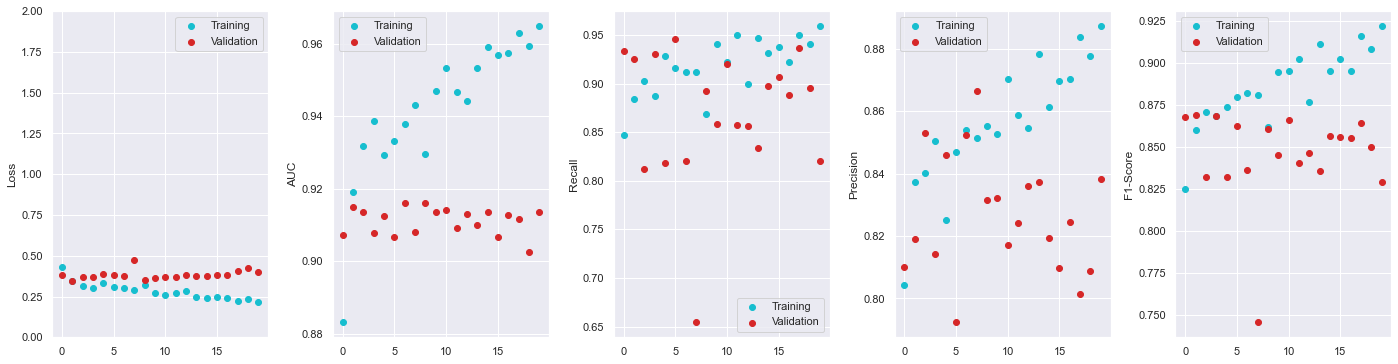

In [53]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'twolayer_finetune_13percent_resnet101_1.pkl')))

## Fine-tuned Model with 3 percent of Positive Class (128 total images)
Clearly with our first set of finetuned hyperparameters we are overfitting. So in the next set of studies, we increase dropout.
### Fine-tuned Parameters
- Learning Rate: 0.001
- Drop Out Rate: 0.25
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- Epochs: 10
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- Color Jitter Intensity Factor: 0.5
- Gaussian Blur Probability: 0.5

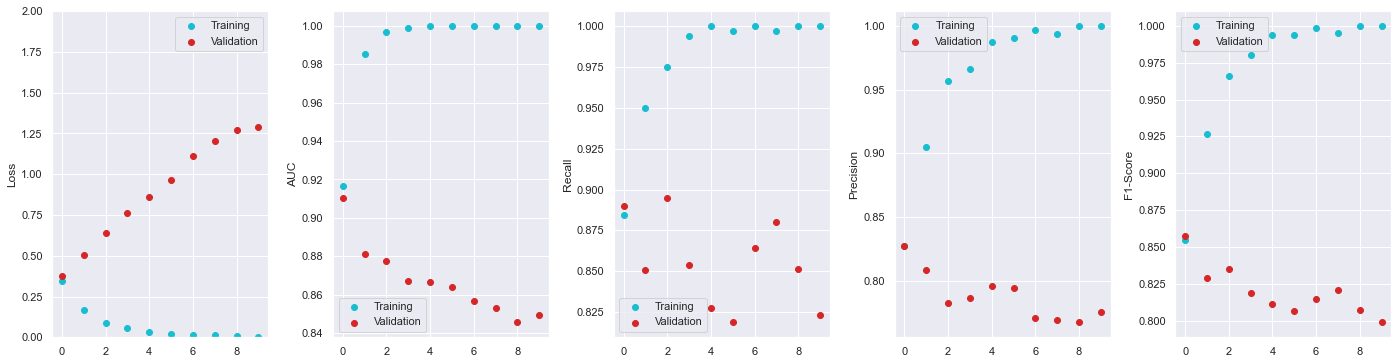

In [29]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_aug1_3percent.pkl')))

## Fine-tuned Model with 3 percent of Positive Class (128 total images)
Overfitting is significantly reduced with increased dropout. We achieve an AUC of ~0.91 with only 128 total training images! And even after just one epoch, our metrics show quite good performance. Training a supervised model with the same amount of data, we can only achieve an AUC of ~0.8. 
- Learning Rate: 0.001
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- Epochs: 10
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- Color Jitter Intensity Factor: 0.5
- Gaussian Blur Probability: 0.5

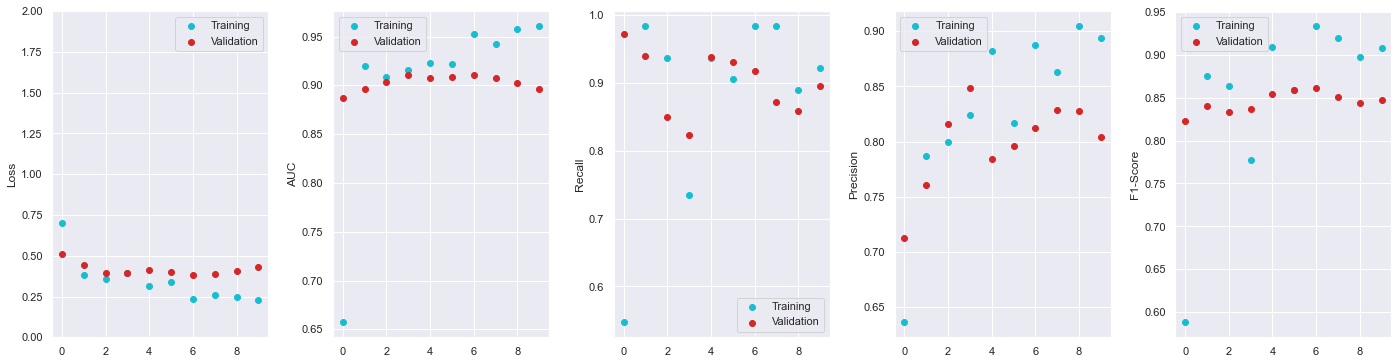

In [30]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50.pkl')))

## Fine-tuned Model with 3 percent of Positive Class (128 total images)
With increased dropout and decreased learning rate, we achieve similar results to those above but with slightly more stable validation set metrics. I would suggest using these finetuning parameters moving forward.
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- Epochs: 10
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- Color Jitter Intensity Factor: 0.5
- Gaussian Blur Probability: 0.5

0.9004888534545898


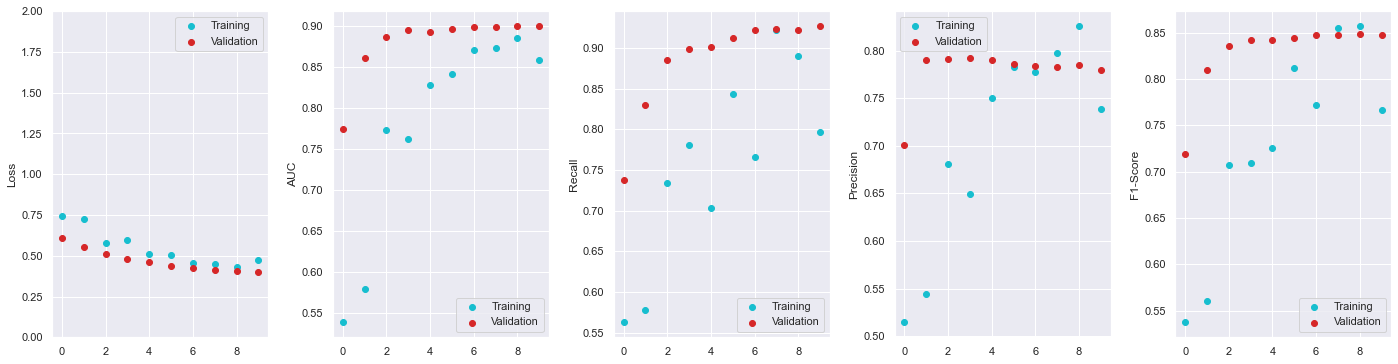

In [54]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001.pkl')))

## Fine-tuned Model with 13 percent of Positive Class (640 total images)
Same as the case above, training with the lower learning rate we see stable training benefits. We may want to increase the number of epochs to determine
where the benefit of training ends (we always use early stopping but with patience of 15 epochs)
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- Epochs: 10
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- Color Jitter Intensity Factor: 0.5
- Gaussian Blur Probability: 0.5

0.9091939330101013


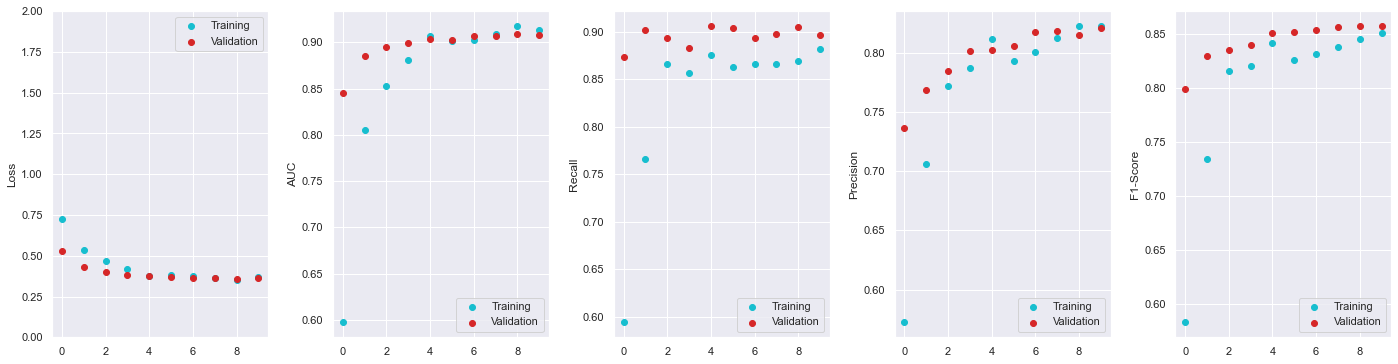

In [55]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_13percent_do50_lr0001.pkl')))

## Fine-tuned Model with 13 percent of Positive Class (640 total images)
As we noted above, the continued training, with a low learning rate, does appear to improve finetuned model performance. Our final model will be finetuned for 50 epochs with early stopping.
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- **Epochs: 30**
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- Color Jitter Intensity Factor: 0.5
- Gaussian Blur Probability: 0.5

0.9156844019889832


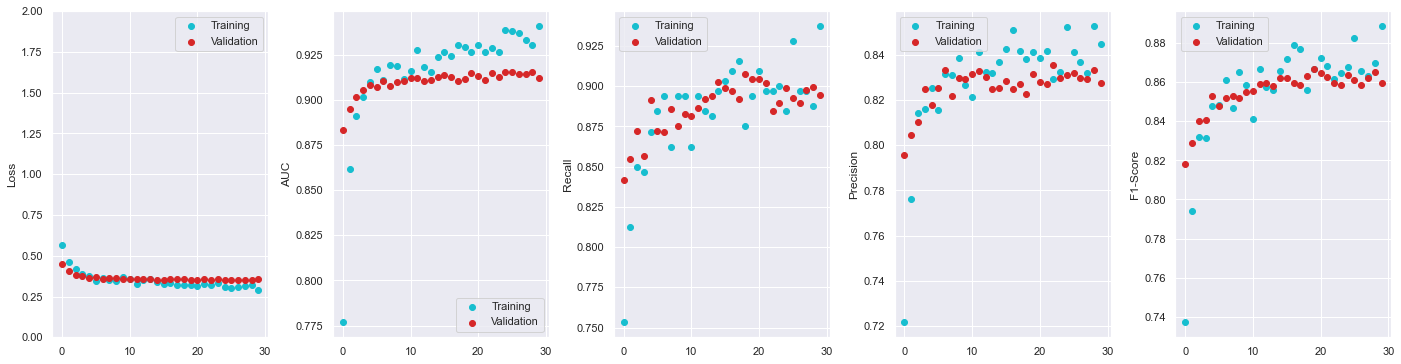

In [56]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_13percent_do50_lr0001_30ep.pkl')))

## Comparison of Color Jitter Intensity
## Fine-tuned Model with 3 percent of Positive Class (128 total images)
As we noted above, the continued training, with a low learning rate, does appear to improve finetuned model performance. Our final model will be finetuned for 50 epochs with early stopping.
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- **Epochs: 30**
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- **Color Jitter Intensity Factor: 1.0, 0.75, 0.50, 0.25 (respectively for plots below - baseline assumption was 0.50)**
- Gaussian Blur Probability: 0.5

First Plot - Intensity Factor of 1.0
0.8879573941230774
Second Plot - Intensity Factor of 0.75
0.9146475195884705
Third Plot - Intensity Factor of 0.50
0.9139231443405151
Fourth Plot - Intensity Factor of 0.25
0.9063875675201416


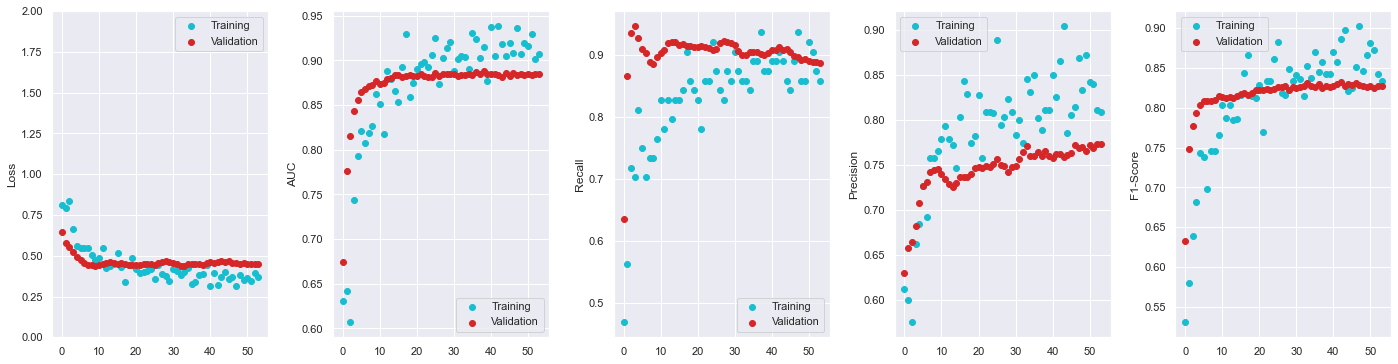

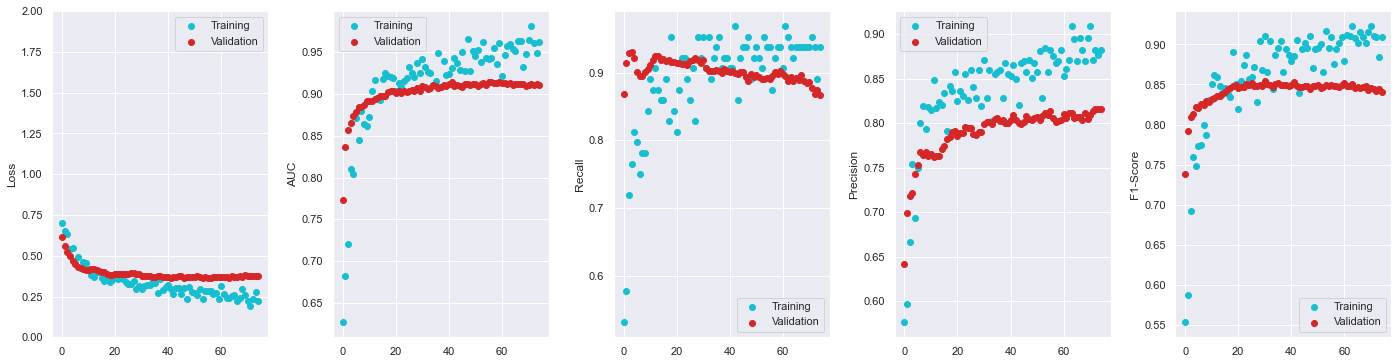

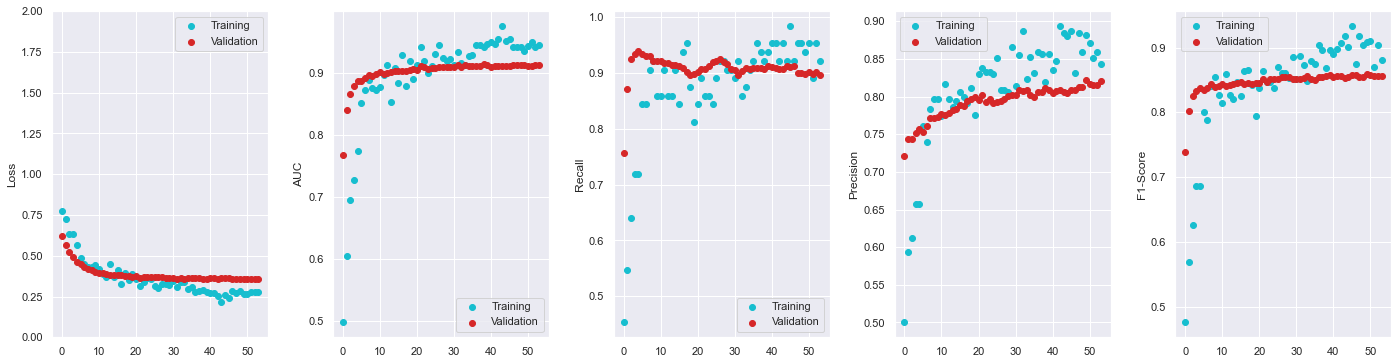

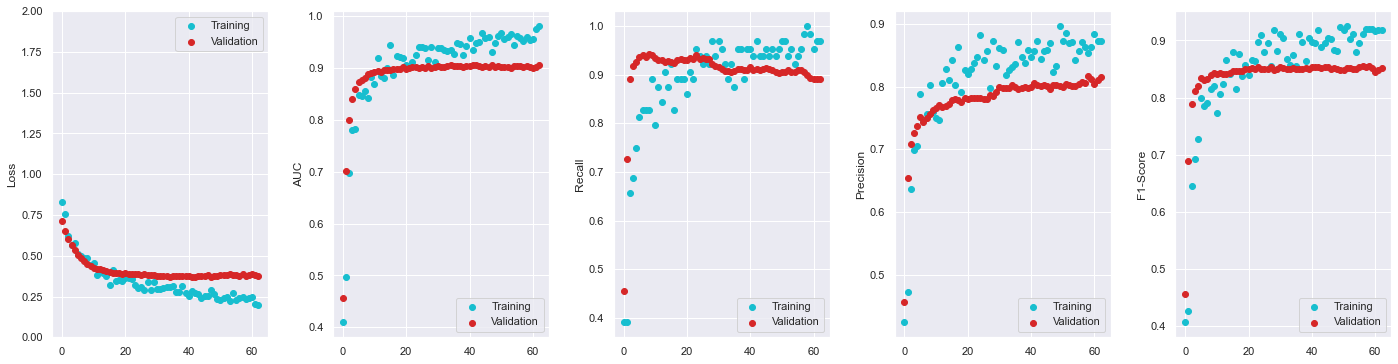

In [57]:
print("First Plot - Intensity Factor of 1.0")
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_s100_e100.pkl')))
print("Second Plot - Intensity Factor of 0.75")
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_s75_e100.pkl')))
print("Third Plot - Intensity Factor of 0.50")
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_s50_e100.pkl')))
print("Fourth Plot - Intensity Factor of 0.25")
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_s25_e100.pkl')))

## Zoom Sensitivity
## Fine-tuned Model with 3 percent of Positive Class (128 total images)
As we noted above, the continued training, with a low learning rate, does appear to improve finetuned model performance. Our final model will be finetuned for 50 epochs with early stopping.
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- **Epochs: 100 with early stopping**
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- **Zoom Ratio: 0.4**
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- **Color Jitter Intensity Factor: 0.50**
- Gaussian Blur Probability: 0.5

0.915580153465271


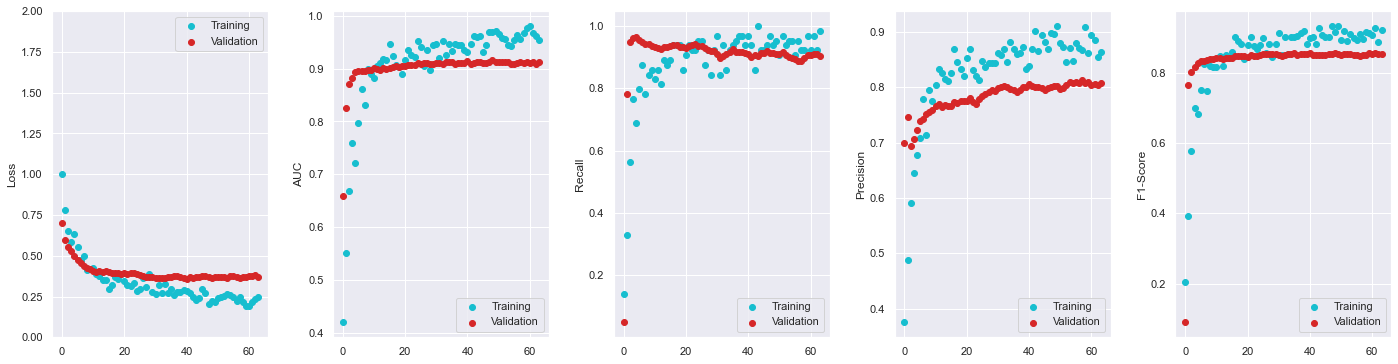

In [58]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_s50_e100_zoom.pkl')))

## Rotation with Zoom Sensitivity
## Fine-tuned Model with 3 percent of Positive Class (128 total images)
As we noted above, the continued training, with a low learning rate, does appear to improve finetuned model performance. Our final model will be finetuned for 50 epochs with early stopping.
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- Temperature used in Softmax: 0.1
- Batch Size: 128
- **Epochs: 30**
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- **Rotation: 90**
- X-Y Shift: 0.1
- **Zoom Ratio: 0.4**
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- **Color Jitter Intensity Factor: 0.50**
- Gaussian Blur Probability: 0.5

0.91131991147995


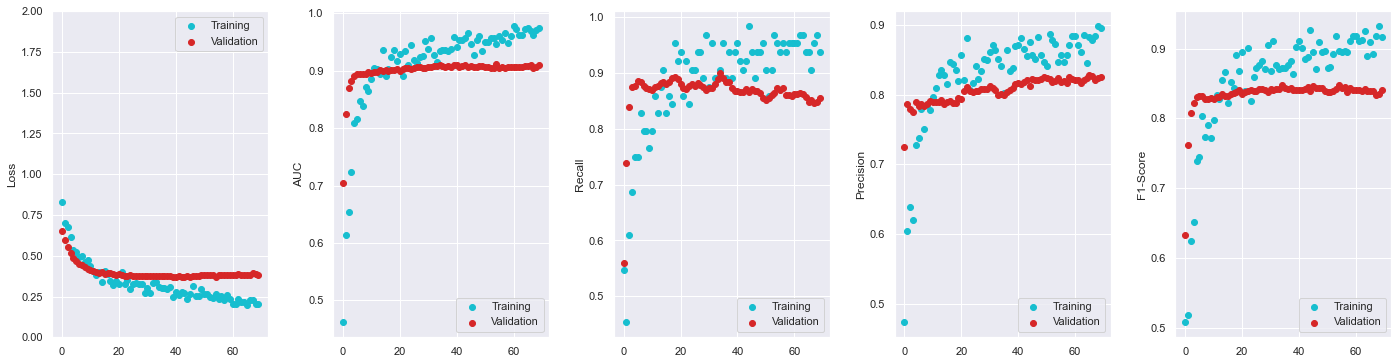

In [62]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_s50_zoom40_rot90_e100.pkl')))

## Temperature Sensitivity
## Fine-tuned Model with 3 percent of Positive Class (128 total images)
As we noted above, the continued training, with a low learning rate, does appear to improve finetuned model performance. Our final model will be finetuned for 100 epochs with early stopping.
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- **Temperature used in Softmax: 0.3**
- Batch Size: 128
- **Epochs: 100**
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- Zoom Ratio: 0.2
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- **Color Jitter Intensity Factor: 0.50**
- Gaussian Blur Probability: 0.5

0.9192765951156616


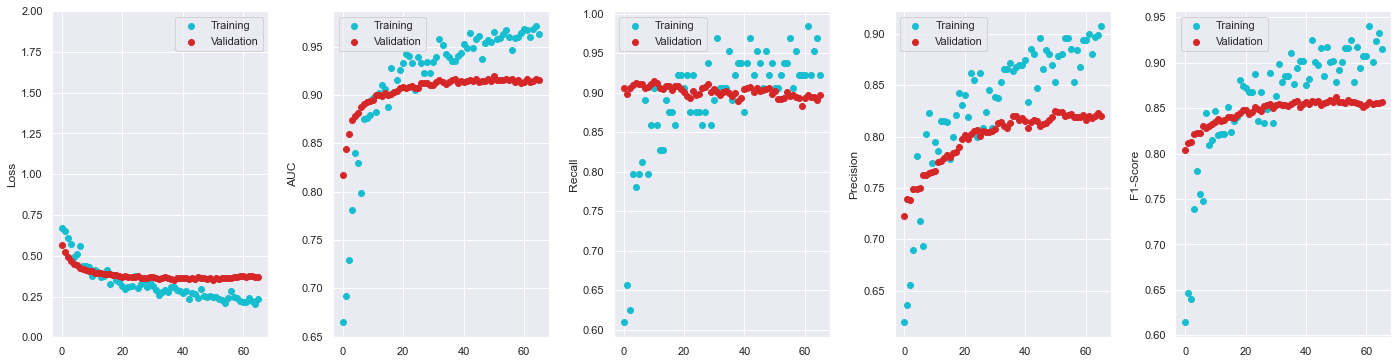

In [71]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_temp3_s50_e100.pkl')))

## Hybrid Sensitivity
## Fine-tuned Model with 3 percent of Positive Class (128 total images)
As we noted above, the continued training, with a low learning rate, does appear to improve finetuned model performance. Our final model will be finetuned for 100 epochs with early stopping.
- **Learning Rate: 0.0001**
- **Drop Out Rate: 0.50**
- Hidden 1 Dimension: 256
- Hidden 2 Dimension: 256
- Hidden Activation: ELU
### Unsupervised Parameters
- **Temperature used in Softmax: 0.3**
- Batch Size: 128
- **Epochs: 100**
- Projection Head 1: 1024 
- Projection Head 2: 512
- Final Dimension: 128
- Geometry Aug Probability: 1.0
- Rotation: 180
- X-Y Shift: 0.1
- **Zoom Ratio: 0.4**
- Grey Scale Probability: 0.20
- Color Jitter Probability: 0.80
- **Color Jitter Intensity Factor: 0.50**
- Gaussian Blur Probability: 0.5

0.9092038869857788


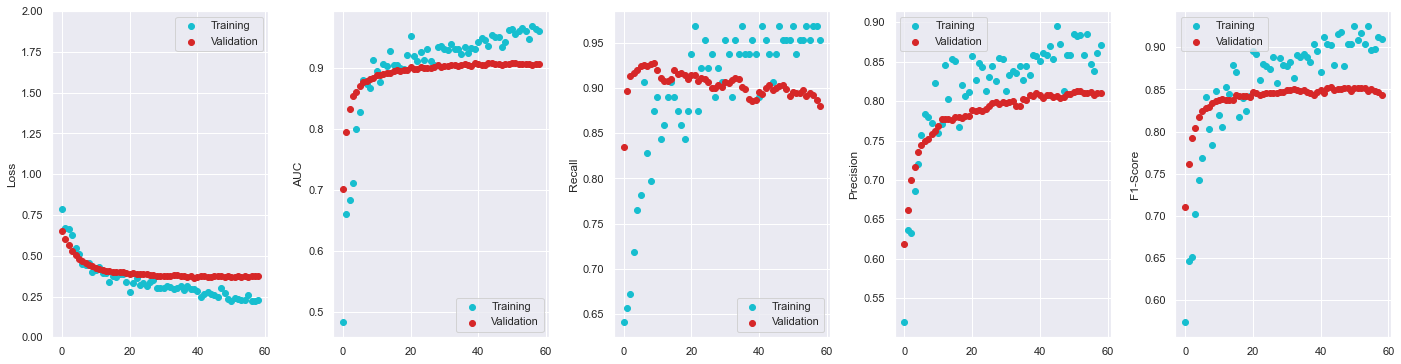

In [68]:
plot_metrics(pd.read_pickle(os.path.join(model_path, 'simclr_finetune_3percent_do50_lr0001_s75_e100_zoom_t3.pkl')))

# Cells below used for Determining Supervised Baseline
## Supervised Baseline: InceptionV3, Upsampled to 5x positive class, Balanced

In [4]:
inception_files = sorted([ file for file in os.listdir(model_path) if file[-3:]=='pkl' if 'inception' in file])

## Five balanced training runs with Inception V3
### Used different subsamples of negative class

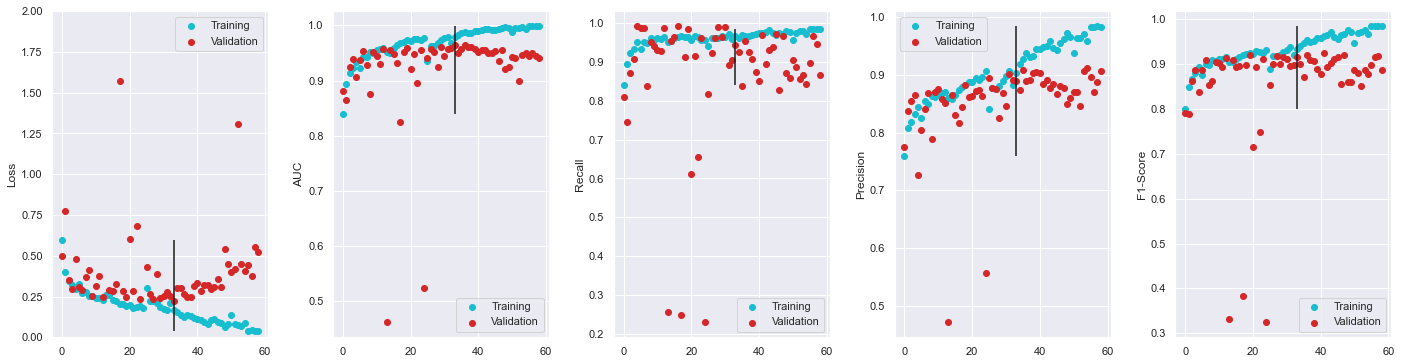

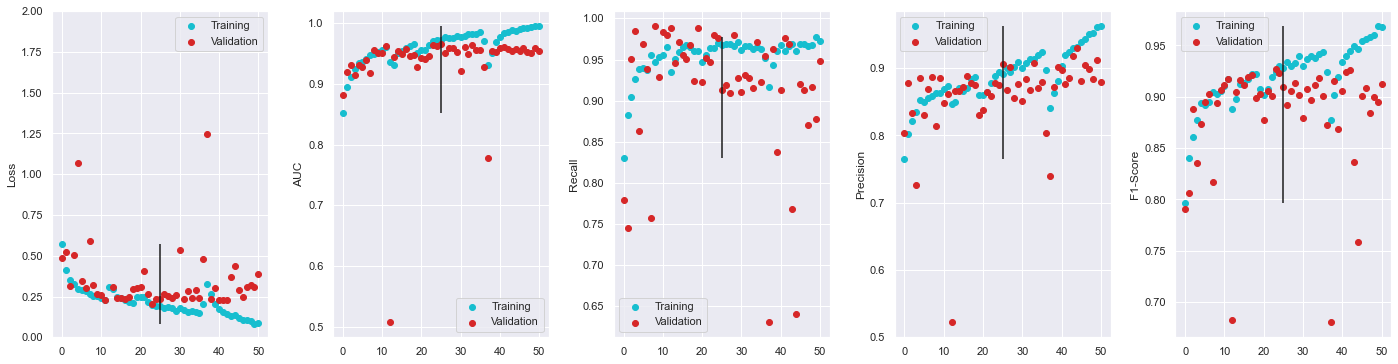

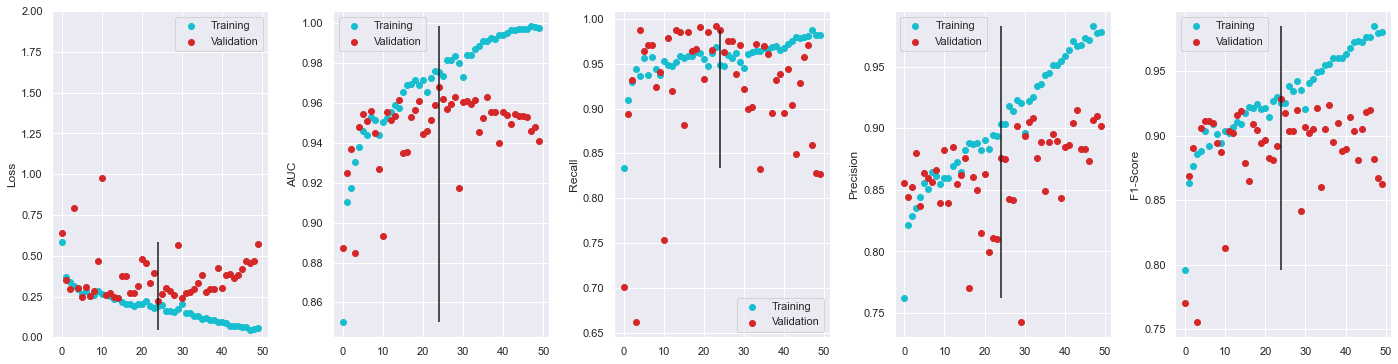

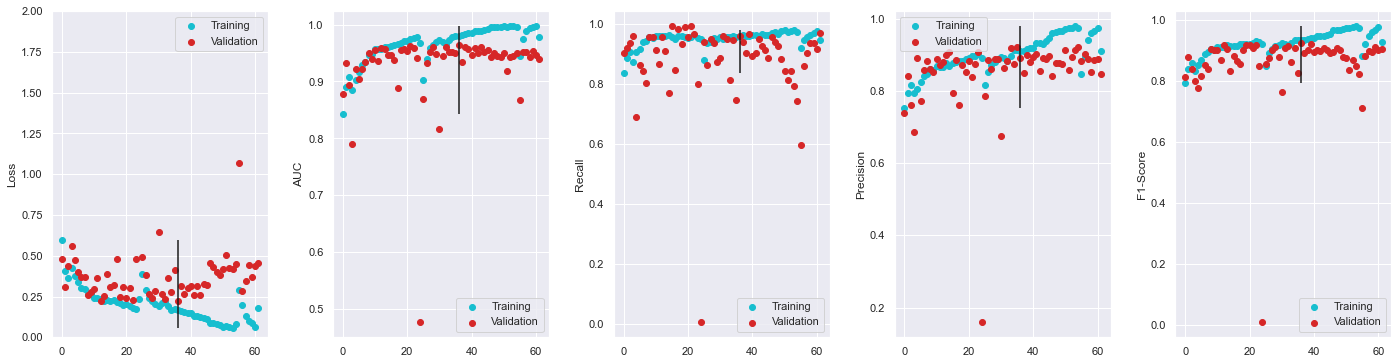

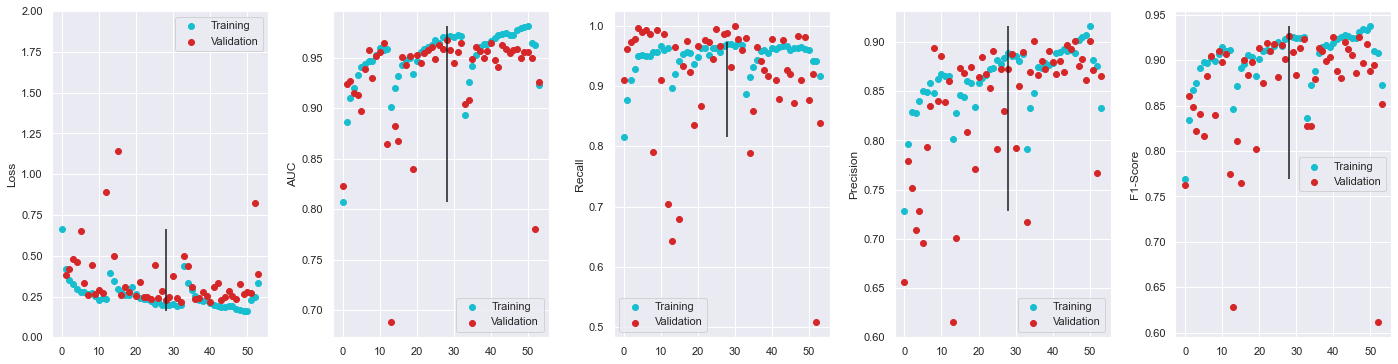

In [5]:
for file in inception_files:
    df = pd.read_pickle(os.path.join(model_path,file))
    plot_metrics(df)

In [6]:
resnet_files = sorted([ file for file in os.listdir(model_path) if file[-3:]=='pkl' if 'resnet' in file])

## Five balanced training runs with ResNet50
### Used different subsamples of negative class

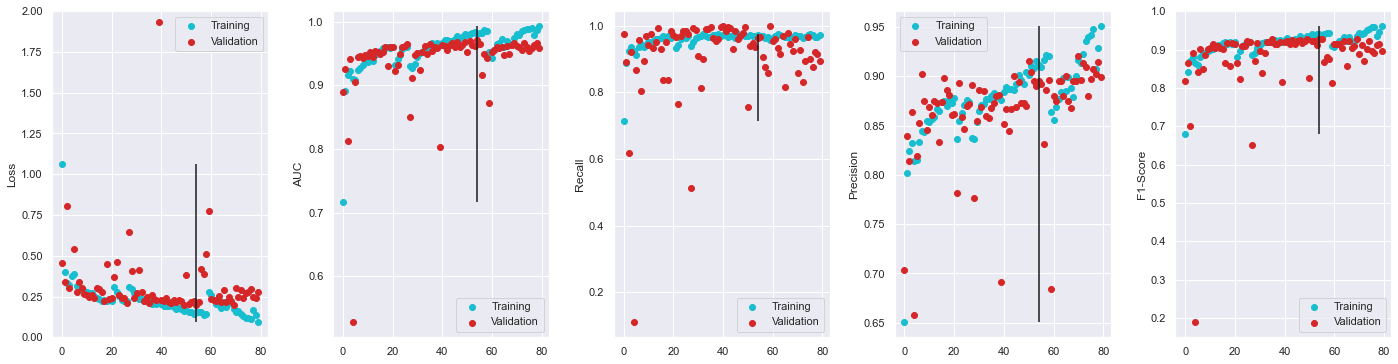

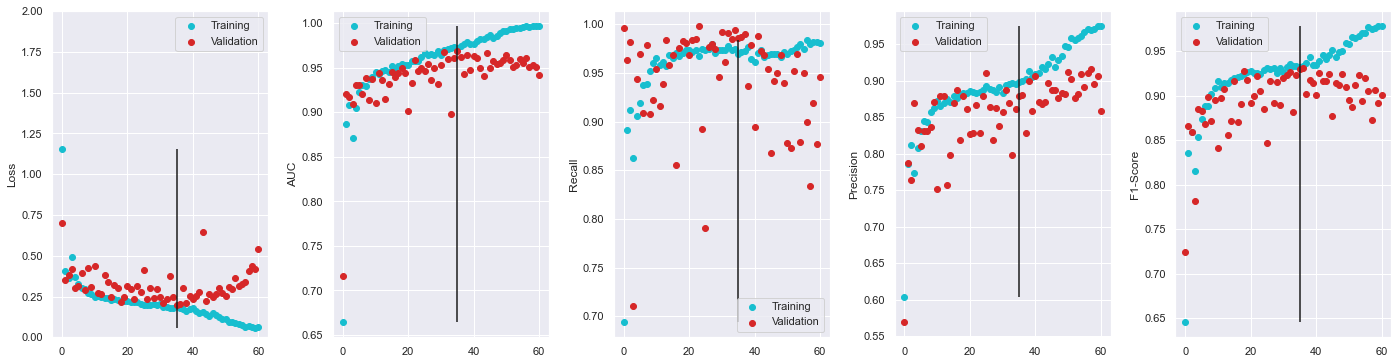

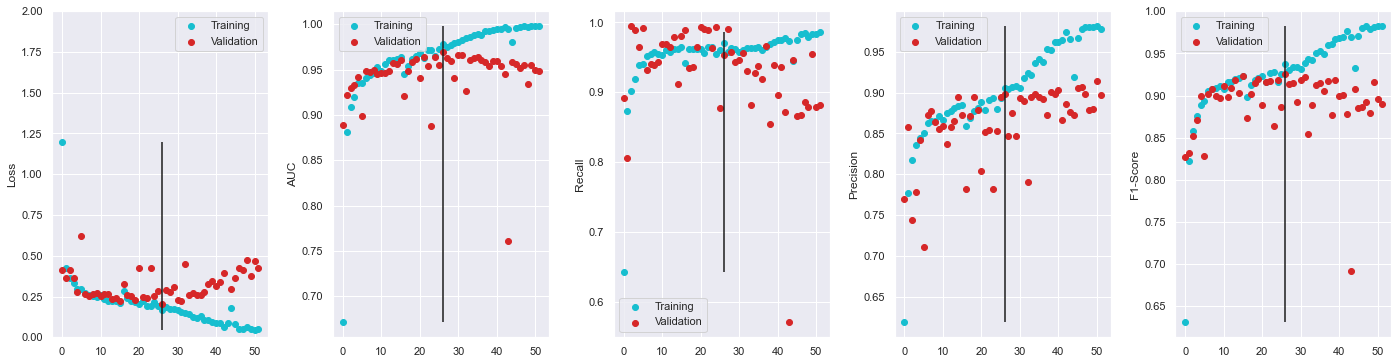

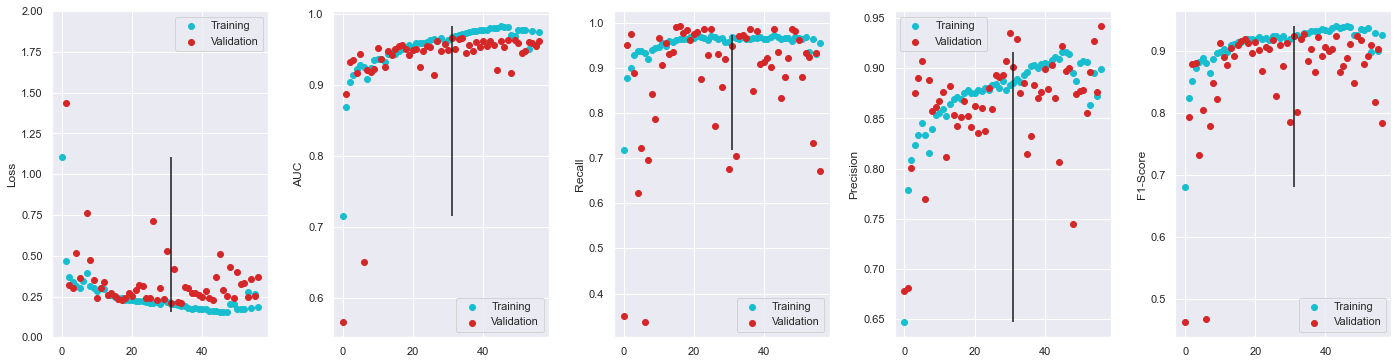

In [7]:
for file in resnet_files:
    df = pd.read_pickle(os.path.join(model_path,file))
    plot_metrics(df)

## Function for Plotting the Confusion Matrix

In [31]:
def plot_cm(name, labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(f'{name}\nConfusion matrix @{threshold:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Images: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([85,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Preliminary Evaluations during down-selection of Supervised Baseline are below

In [9]:
inception_models = sorted([ file for file in os.listdir(model_path) if file[-2:]=='h5' if 'inception' in file])
print(inception_models)
resnet_models = sorted([ file for file in os.listdir(model_path) if file[-2:]=='h5' if 'resnet' in file])
print(resnet_models)

['pooled_inception_balanced_val_all.h5', 'pooled_inceptionv3_balanced_val_0.h5', 'pooled_inceptionv3_balanced_val_1.h5', 'pooled_inceptionv3_balanced_val_2.h5', 'pooled_inceptionv3_balanced_val_3.h5', 'pooled_inceptionv3_balanced_val_4.h5']
['pooled_resnet50_balanced_val_0.h5', 'pooled_resnet50_balanced_val_1.h5', 'pooled_resnet50_balanced_val_2.h5', 'pooled_resnet50_balanced_val_3.h5', 'pooled_resnet50_balanced_val_4.h5', 'pooled_resnet50_balanced_val_all.h5']


In [8]:
upsampled_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_inception_balanced_val_all.h5'))
upsampled_rn_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_resnet50_balanced_val_all.h5'))

In [18]:
ens_predictions = []
inc_predictions = [] 
rn_predictions = []
labels = []
for image_batch, label_batch in balanced_test_data:
    p1 = upsampled_model.predict(image_batch)
    p2 = upsampled_rn_model.predict(image_batch)
    inc_predictions.append(p1)
    rn_predictions.append(p2)
    ens_predictions.append(np.mean([p1,p2],axis=0))
    labels.append(label_batch.numpy())
labels_array = np.concatenate(labels)
inc_pred_array = np.concatenate(inc_predictions)
rn_pred_array = np.concatenate(rn_predictions)
ens_pred_array = np.concatenate(ens_predictions)
    


W1010 15:34:48.409590 4471250368 def_function.py:120] 7 out of the last 742 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa0d62ee680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
W1010 15:34:49.804481 4471250368 def_function.py:120] 8 out of the last 743 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa0e991c8c0> triggered tf.function retracing. Traci

True Negatives:  2124
False Positives:  251
False Negatives:  96
True Positives:  2279
Total Images:  2375


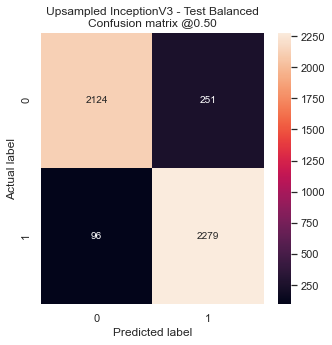

In [19]:
 plot_cm(f"Upsampled InceptionV3 - Test Balanced", labels_array, inc_pred_array)

True Negatives:  2104
False Positives:  271
False Negatives:  92
True Positives:  2283
Total Images:  2375


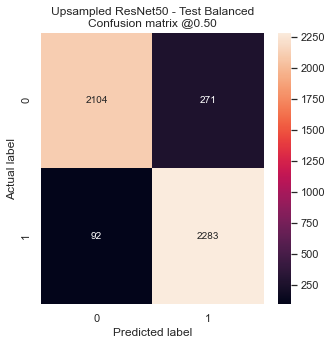

In [20]:
 plot_cm(f"Upsampled ResNet50 - Test Balanced", labels_array, rn_pred_array)

True Negatives:  2115
False Positives:  260
False Negatives:  74
True Positives:  2301
Total Images:  2375


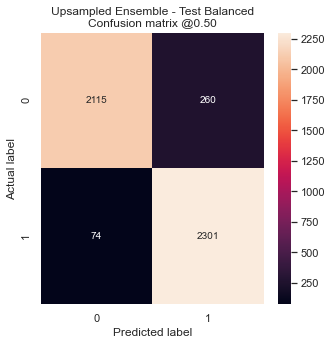

In [21]:
 plot_cm(f"Upsampled Ensemble - Test Balanced", labels_array, ens_pred_array)

## Compare Resnet vs Inception
### Ensemble Model (vote from five different models) performs basically the same as Upsampled Model
### Upsampled Model will be Supervised Baseline due to it being simpler

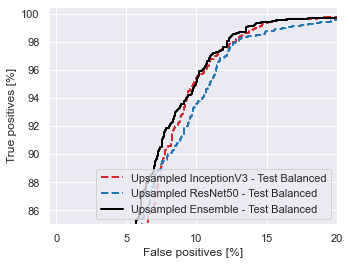

In [22]:
plot_roc(f"Upsampled InceptionV3 - Test Balanced", labels_array, inc_pred_array, color='tab:red', linestyle='--')
plot_roc(f"Upsampled ResNet50 - Test Balanced", labels_array, rn_pred_array, color='tab:blue', linestyle='--')
plot_roc(f"Upsampled Ensemble - Test Balanced", labels_array, ens_pred_array, color='black', linestyle='-')
plt.legend(loc='lower right')

In [193]:
ens_predictions_skewed = []
inc_predictions_skewed = [] 
rn_predictions_skewed = []
labels_skewed = []
for image_batch, label_batch in skewed_test_data:
    p1 = upsampled_model.predict(image_batch)
    p2 = upsampled_rn_model.predict(image_batch)
    inc_predictions_skewed.append(p1)
    rn_predictions_skewed.append(p2)
    ens_predictions_skewed.append(np.mean([p1,p2],axis=0))
    labels_skewed.append(label_batch.numpy())
skewed_labels_array = np.concatenate(labels_skewed)
skewed_inc_pred_array = np.concatenate(inc_predictions_skewed)
skewed_rn_pred_array = np.concatenate(rn_predictions_skewed)
skewed_ens_pred_array = np.concatenate(ens_predictions_skewed)

True Negatives:  19001
False Positives:  2374
False Negatives:  96
True Positives:  2279
Total Images:  2375


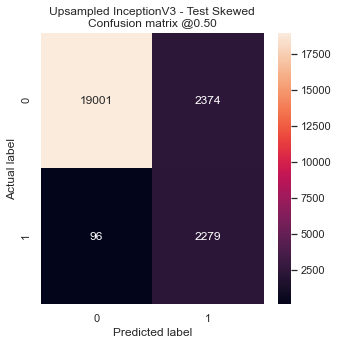

In [194]:
 plot_cm(f"Upsampled InceptionV3 - Test Skewed", skewed_labels_array, skewed_inc_pred_array)

True Negatives:  18801
False Positives:  2574
False Negatives:  92
True Positives:  2283
Total Images:  2375


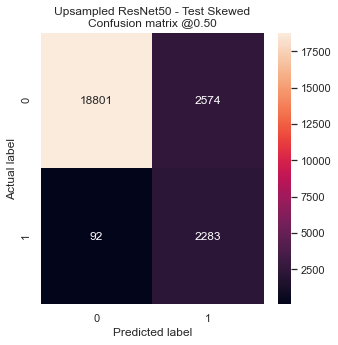

In [195]:
 plot_cm(f"Upsampled ResNet50 - Test Skewed", skewed_labels_array, skewed_rn_pred_array)

True Negatives:  18931
False Positives:  2444
False Negatives:  74
True Positives:  2301
Total Images:  2375


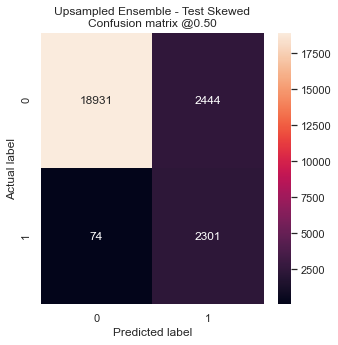

In [196]:
 plot_cm(f"Upsampled Ensemble - Test Skewed", skewed_labels_array, skewed_ens_pred_array)

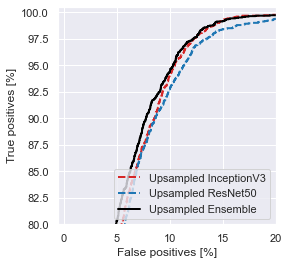

In [197]:
plot_roc(f"Upsampled InceptionV3", skewed_labels_array, skewed_inc_pred_array, color='tab:red', linestyle='--')
plot_roc(f"Upsampled ResNet50", skewed_labels_array, skewed_rn_pred_array, color='tab:blue', linestyle='--')
plot_roc(f"Upsampled Ensemble", skewed_labels_array, skewed_ens_pred_array, color='black', linestyle='-')
plt.legend(loc='lower right')

## Generate Predictions for Ensemble of Balanced Learners
We trained five models using different samples of negative examples. We average the predictions to determine a less variant prediction.

In [9]:
i0_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_inceptionv3_balanced_val_0.h5'))
i1_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_inceptionv3_balanced_val_1.h5'))
i2_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_inceptionv3_balanced_val_2.h5'))
i3_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_inceptionv3_balanced_val_3.h5'))
i4_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_inceptionv3_balanced_val_4.h5'))

ens_predictions = []
inc0_predictions = [] 
inc1_predictions = [] 
inc2_predictions = [] 
inc3_predictions = [] 
inc4_predictions = [] 
incup_predictions = []

labels = []
for image_batch, label_batch in balanced_test_data:
    p0 = i0_model.predict(image_batch)
    p1 = i1_model.predict(image_batch)
    p2 = i2_model.predict(image_batch)
    p3 = i3_model.predict(image_batch)
    p4 = i4_model.predict(image_batch)
    pup = upsampled_model.predict(image_batch)
    inc0_predictions.append(p0)
    inc1_predictions.append(p1)
    inc2_predictions.append(p2)
    inc3_predictions.append(p3)
    inc4_predictions.append(p4)
    incup_predictions.append(pup)
    ens_predictions.append(np.mean([p0,p1,p2,p3,p4],axis=0))
    labels.append(label_batch.numpy())
# Create array of actual lables
labels_array = np.concatenate(labels)

# Create the five arrays of predicitons
# One for each model that was generated with different negative examples
inc0_pred_array = np.concatenate(inc0_predictions)
inc1_pred_array = np.concatenate(inc1_predictions)
inc2_pred_array = np.concatenate(inc2_predictions)
inc3_pred_array = np.concatenate(inc3_predictions)
inc4_pred_array = np.concatenate(inc4_predictions)

# Create an ensemble array using the average prediction
ens_pred_array = np.concatenate(ens_predictions)

# Create the upsampled predictions array
up_pre_array = np.concatenate(incup_predictions)

W1017 10:50:26.974182 4479057344 def_function.py:120] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f94a5a0fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
W1017 10:50:28.532803 4479057344 def_function.py:120] 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9495bef680> triggered tf.function retracing. Tracing i

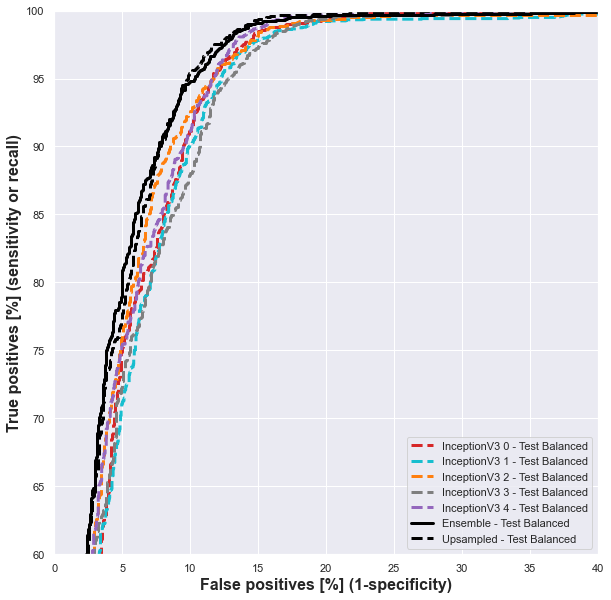

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_roc_full(f"InceptionV3 0 - Test Balanced", labels_array, inc0_pred_array, color='tab:red', linestyle='--')
plot_roc_full(f"InceptionV3 1 - Test Balanced", labels_array, inc1_pred_array, color='tab:cyan', linestyle='--')
plot_roc_full(f"InceptionV3 2 - Test Balanced", labels_array, inc2_pred_array, color='tab:orange', linestyle='--')
plot_roc_full(f"InceptionV3 3 - Test Balanced", labels_array, inc3_pred_array, color='tab:gray', linestyle='--')
plot_roc_full(f"InceptionV3 4 - Test Balanced", labels_array, inc4_pred_array, color='tab:purple', linestyle='--')
plot_roc_full(f"Ensemble - Test Balanced", labels_array, ens_pred_array, color='black', linestyle='-')
plot_roc_full(f"Upsampled - Test Balanced", labels_array, up_pre_array, color='black', linestyle='--')
plt.legend(loc='lower right')

## Evaluation of Data Augmentation Techniques
We evaluate different augmentation techniques to determine which may be viable for use with our SimCLR unclassified learning process. We are looking for augmentation techniques that do not greatly reduce the efficacy of our model's ability to learn. If they do that would indicate the augmentation technique is destroying valuable information in our inputs.

In [8]:
i0_model = tf.keras.models.load_model(os.path.join(model_path, 'pooled_inceptionv3_balanced_val_0.h5'))
i0_shift_model = tf.keras.models.load_model(os.path.join(model_path, 'bl_inc_aug_shift_0.h5'))
i0_blur_model = tf.keras.models.load_model(os.path.join(model_path, 'bl_inc_aug_blur_0.h5'))
i0_cs_model = tf.keras.models.load_model(os.path.join(model_path, 'bl_inc_aug_chanshift_0.h5'))
i0_all_model = tf.keras.models.load_model(os.path.join(model_path, 'bl_inc_aug_all_df_0.h5'))
i0_allsimclr_model = tf.keras.models.load_model(os.path.join(model_path, 'bl_inc_aug_simclr_df_0.h5'))

In [42]:
labels = []
inc0_predictions = [] 
shift0_predictions= []
blur0_predictions= []
cs0_predictions = []
all0_predictions = []
simclr0_predictions = []
for image_batch, label_batch in balanced_test_data:
    shift0 = i0_shift_model.predict(image_batch)
    cs0 = i0_cs_model.predict(image_batch)
    blur0 = i0_blur_model.predict(image_batch)
    p0 = i0_model.predict(image_batch)
    all0 = i0_all_model.predict(image_batch)
    simclr0 = i0_simclr_model.predict(image_batch)
    simclr0_predictions.append(simclr0)
    inc0_predictions.append(p0)
    blur0_predictions.append(blur0)
    shift0_predictions.append(shift0)
    cs0_predictions.append(cs0)
    all0_predictions.append(all0)
    labels.append(label_batch.numpy())
# Create array of actual lables
labels_array = np.concatenate(labels)

# Create the five arrays of predicitons
# One for each model that was generated with different negative examples
shift0_pred_array = np.concatenate(shift0_predictions)
cs0_pred_array = np.concatenate(cs0_predictions)
blur0_pred_array = np.concatenate(blur0_predictions)
inc0_pred_array = np.concatenate(inc0_predictions)
all0_pred_array = np.concatenate(all0_predictions)
simclr0_pred_array = np.concatenate(simclr0_predictions)

In [11]:
def plot_roc_full(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=3, **kwargs)
  plt.xlabel('False positives [%] (1-specificity)', fontweight='bold', fontsize=16)
  plt.ylabel('True positives [%] (sensitivity or recall)', fontweight='bold', fontsize=16)
  plt.xlim([0,40])
  plt.ylim([60,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

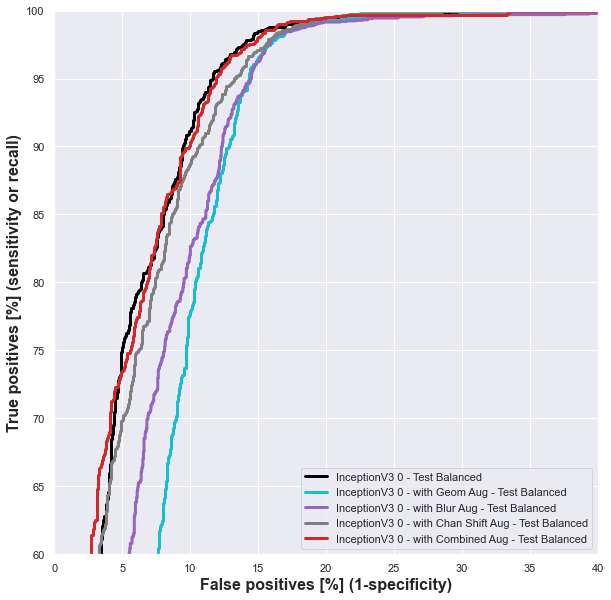

In [61]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_roc_full(f"InceptionV3 0 - Test Balanced", labels_array, inc0_pred_array, color='black')
plot_roc_full(f"InceptionV3 0 - with Geom Aug - Test Balanced", labels_array, shift0_pred_array, color='tab:cyan')
plot_roc_full(f"InceptionV3 0 - with Blur Aug - Test Balanced", labels_array, blur0_pred_array, color='tab:purple')
plot_roc_full(f"InceptionV3 0 - with Chan Shift Aug - Test Balanced", labels_array, cs0_pred_array, color='tab:gray')
plot_roc_full(f"InceptionV3 0 - with Combined Aug - Test Balanced", labels_array, all0_pred_array, color='tab:red')
plt.legend(loc='lower right')

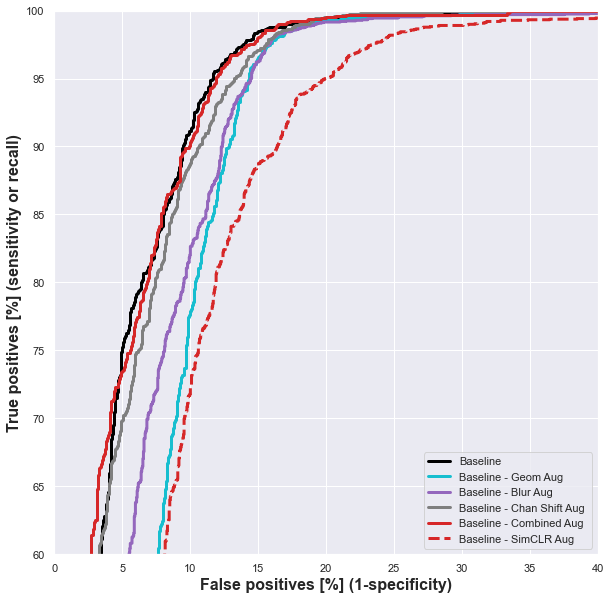

In [62]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_roc_full(f"Baseline", labels_array, inc0_pred_array, color='black')
plot_roc_full(f"Baseline - Geom Aug", labels_array, shift0_pred_array, color='tab:cyan')
plot_roc_full(f"Baseline - Blur Aug", labels_array, blur0_pred_array, color='tab:purple')
plot_roc_full(f"Baseline - Chan Shift Aug ", labels_array, cs0_pred_array, color='tab:gray')
plot_roc_full(f"Baseline - Combined Aug", labels_array, all0_pred_array, color='tab:red')
plot_roc_full(f"Baseline - SimCLR Aug", labels_array, simclr0_pred_array, color='tab:red', linestyle='--')
plt.legend(loc='lower right')

In [64]:
simclr2_model = tf.keras.models.load_model(os.path.join(model_path, 'bl_inc_aug_simclr2_0.h5'))

labels2 = []
simclr20_predictions = []
for image_batch, label_batch in balanced_test_data:
    simclr20 = simclr2_model.predict(image_batch)
    simclr20_predictions.append(simclr20)
    labels2.append(label_batch.numpy())
# Create array of actual lables
labels_array2 = np.concatenate(labels2)

# Create the five arrays of predicitons
# One for each model that was generated with different negative examples
simclr20_pred_array = np.concatenate(simclr20_predictions)

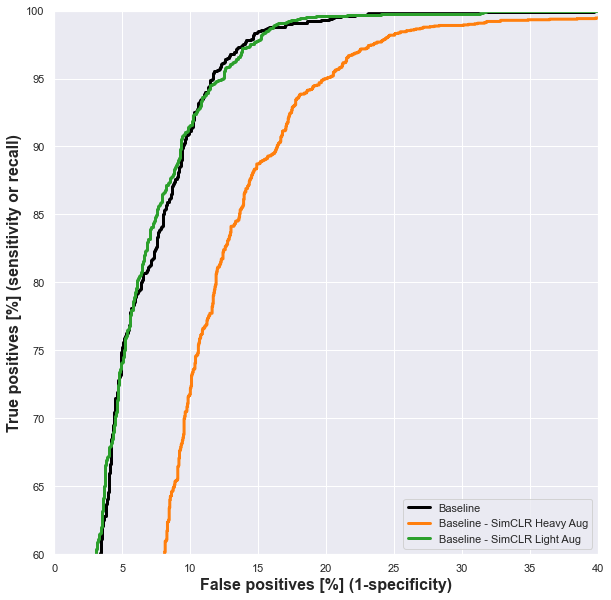

In [69]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_roc_full(f"Baseline", labels_array, inc0_pred_array, color='black')
#plot_roc_full(f"Baseline - Geom Aug", labels_array, shift0_pred_array, color='tab:cyan')
#plot_roc_full(f"Baseline - Blur Aug", labels_array, blur0_pred_array, color='tab:purple')
#plot_roc_full(f"Baseline - Chan Shift Aug ", labels_array, cs0_pred_array, color='tab:gray')
#plot_roc_full(f"Baseline - Combined Aug", labels_array, all0_pred_array, color='tab:red')
plot_roc_full(f"Baseline - SimCLR Heavy Aug", labels_array, simclr0_pred_array, color='tab:orange', linestyle='-')
plot_roc_full(f"Baseline - SimCLR Light Aug", labels_array2, simclr20_pred_array, color='tab:green', linestyle='-')
plt.legend(loc='lower right')